# Загрузка данных

### Библиотеки

In [1]:
!pip install etna

  Using cached hydra_slayer-0.2.0-py3-none-any.whl (12 kB)
  Attempting uninstall: hydra-slayer
    Found existing installation: hydra-slayer 0.4.0
    Uninstalling hydra-slayer-0.4.0:
      Successfully uninstalled hydra-slayer-0.4.0


In [2]:
!pip install fbprophet

In [3]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import math
import time
from datetime import datetime
from itertools import *
from random import gauss

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import histplot

from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import statsmodels.api as sm
from statsmodels.api import tsa
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.tsatools import lagmat
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.simplefilter("ignore")

In [4]:
import fbprophet
from fbprophet import Prophet

from etna.datasets import TSDataset
from etna.analysis import sample_acf_plot, get_anomalies_density, plot_anomalies, plot_forecast
from etna.metrics import MAE, SMAPE, MSE, MAPE

from etna.pipeline import Pipeline
from etna.transforms import LagTransform, LinearTrendTransform, DensityOutliersTransform, TimeSeriesImputerTransform

from etna.models import MovingAverageModel, SeasonalMovingAverageModel, CatBoostModelPerSegment

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Данные

In [6]:
f = open('/content/gdrive/My Drive/lorenz.txt', 'r')
lorentz_series = np.array([float(line.strip()) for line in f])[20000:25000]
f.close()

In [7]:
ammonia_data = pd.read_csv('/content/gdrive/My Drive/vkr_data/ammonia_spot_prices.csv')

In [8]:
exchange_data = pd.read_excel('/content/gdrive/My Drive/vkr_data/Exchange rate dollar.xlsx')[['data', 'curs']][1996:]
exchange_data.sort_values(by='data', inplace = True)
exchange_data.reset_index(inplace = True, drop = True)

In [9]:
gemini_data = pd.read_csv('/content/gdrive/My Drive/vkr_data/gemini.csv', sep = ',')
gemini_data.drop('Unnamed: 0', axis = 1, inplace = True)

In [34]:
brent = pd.read_csv('/content/gdrive/My Drive/vkr_data/Brent Spot Price.csv', sep = ';')
brent.columns = ['date', 'price']
brent['price'] = brent['price'].apply(lambda x: float(x.replace(',', '.')))

# Основные характеристики

In [16]:
class Series_data:

    def __init__(self, y_ax, t_ax = []):
        self.y_axis = y_ax
        self.length = len(self.y_axis)
        if (len(t_ax) == 0):
            self.t_axis = np.arange(0, self.length)
        else:
            self.t_axis = t_ax
        self.entropy = 0
        self.complexity = 0
    
    def print_info(self):
        print('Кол-во наблюдений: ', self.length)
        print('Минимальное значение: ', round(np.min(self.y_axis), 2))
        print('Максимальное значение: ', round(np.max(self.y_axis), 2))
        print('Среднее значение: ', round(np.mean(self.y_axis), 2))

    def get_visualization(self, fig_size = (24, 8)):
        plt.figure(figsize = fig_size)
        plt.plot(self.t_axis, self.y_axis, color = 'steelblue', linewidth = 1)
        #plt.title('Временной ряд', fontsize = 16)
        plt.show()

    # Проверка ряда на стационарность

    def stationarity_adf_test(self, lev):
        # Расширенный тест Дики-Фуллера
        adf_test = sm.tsa.adfuller(self.y_axis)
        if (adf_test[1] < lev): 
            res = 1
        else:
            res = 0
        return res

    def stationarity_kpss_test(self, lev):
        kpss_test = sm.tsa.kpss(self.y_axis)
        if (kpss_test[1] < lev) :
            res = 0
        else:
            res = 1
        return res

    def plot_acf_and_pacf(self, lag_, fig_size = (24, 10)):
        # Построение автокорреляционной функции и частной автокор. функции
        f = plt.figure(figsize=fig_size)
        ax1 = f.add_subplot(2, 1, 1)
        ax1.set_title('Autocorrelation')
        plot_acf(self.y_axis, lags = lag_, ax = ax1)
        ax2 = f.add_subplot(2, 1, 2)
        ax2.set_title('Partial Autocorrelation')
        plot_pacf(self.y_axis, lags = lag_, ax = ax2)
        plt.show()
    
    def stationarity_test(self, lev = 0.05, lag_ = None, fig_size = (24, 8)):
        test_names = ['ADF-тест', 'KPSS-тест']
        results = [self.stationarity_adf_test(lev), self.stationarity_kpss_test(lev)]
        for t in range(0, len(test_names)):
            if (results[t] == 1):
                res = 'The series is stationary.'
            else:
                res = 'The series is not stationary.'
            print(test_names[t] + ': ' + res)
        self.plot_acf_and_pacf(lag_, fig_size)

    # Энтропия - сложность

    def calculate_entropy(self, prob_vec):
        # Вычисляем энтропию Шенннона
        return - np.sum(prob_vec * np.log(prob_vec))

    def def_N(self, m):
        N_frac = np.math.factorial(m) # общее число возможных перестановок = m!
        return N_frac

    def get_Q0(self, N):
        # Вычисляем нормирующий множитель Q_0
        # Q_0 = - 2/(((N+1)/N)*np.log(N+1) - 2*np.log(2*N) + np.log(N))
        return -2 / ((N+1)/N * np.log(N + 1) - np.log(N) - np.log(4))

    def entropy_complexity(self, m):

        # Переходим к набору z-векторов
        z_vectors = []
        z_count = self.length - m + 1
        for i in range(0, z_count):
            vec = self.y_axis[i:i+m]
            z_vectors.append(vec)

        # Вычисляем распределение вероятностей для ординальных структур
        ord_dict = {}
        for z in z_vectors:
            # Формируем орд. структуру для очередного z-вектора
            ord = np.argsort(z)
            #ord = []
            #for j in range(0, len(z)-1):
            #    if (z[j] <= z[j+1]):
            #        ord.append(1)
            #    else:
            #        ord.append(0)
    
            # Проверяем, встречалась ли такая структура ранее, обновляем ее частоту
            ord_s = np.array(ord).tobytes()
            if ord_s not in ord_dict:
                ord_dict[ord_s] = 1
            else:
                ord_dict[ord_s] += 1

        freq = list(ord_dict.values())
        ord_prob = np.array(freq) / np.sum(freq)

        N = self.def_N(m)

        # Вычисляем расхождение между рассматриваемым распределением и равномерным
        H_ord = self.calculate_entropy(ord_prob) # энтропия для распределения ординальных структур P
        H_e = np.log(N) # энтропия для равномерного распределения P_e
        H_sum = (N - len(ord_prob)) / (2 * N) * (np.log(2) + np.log(N)) + self.calculate_entropy(0.5 * ord_prob + 0.5 * (1/N)) # энтропия (P + P_e)/2
        dist_J_S = H_sum - 0.5 * H_ord - 0.5 * H_e

        #  нормируем энтропию для распределения ординальных структур
        H_ord = H_ord / np.log(N)

        # Вычисляем MPR-сложность: C_mpr = Q_0 * H(P) * D(P||P_e)
        C_mpr = self.get_Q0(N) * H_ord * dist_J_S

        self.entropy, self.complexity = H_ord, C_mpr
        
        return H_ord, C_mpr


### Энтропия-сложность

In [17]:
def s_b(N, p, k):
    if p != 0:
        return -(k * p * math.log(p) + (1 - p * k) * math.log((1 - p * k) / (N - k)))
    else:
        return math.log(N - k)

def s_b_1(N, p, k):
    return -(
        k * (p + 1 / N) / 2 * math.log((p + 1 / N) / 2) + \
        (N - k) * ((1 - p * k) / (N - k) + 1 / N) / 2 * math.log((((1 - p * k) / (N - k)) + 1 / N) / 2))

def entropy_b(N, p, k):
    return s_b(N, p, k) / math.log(N)

def q_0_b(N):
    return 1 / (s_b(N, 1 / (2 * N), N - 1) - math.log(N) / 2)

def q_j_b(N, p, k):
    return q_0_b(N) * (s_b_1(N, p, k) - s_b(N, p, k) / 2 - math.log(N) / 2)

def complexity_b(N, p, k, ent=None):
    if ent is None:
        ent = entropy_b(N, p, k)
    return q_j_b(N, p, k) * ent

def entropy_complexity_b(N, p, k):
    e_b = entropy_b(N, p, k)
    c_b = complexity_b(N, p, k, e_b)
    return e_b, c_b

def get_borders(m):
    N = np.math.factorial(m)
    i = 1
    entropy = []
    complexity = []
    while i * 100 < N:
        for k in range(N - i * 100, N - 1, i):
            e_b, c_b = entropy_complexity_b(N, 0, k)
            entropy.append(e_b)
            complexity.append(c_b)
        i *= 2
    for k in range(0, N - 1, i):
        e_b, c_b = entropy_complexity_b(N, 0, k)
        entropy.append(e_b)
        complexity.append(c_b)
    idx = np.argsort(entropy)
    entropy = np.array(entropy)[idx]
    complexity = np.array(complexity)[idx]
    max_ec = np.vstack([entropy, complexity]).T
    max_ec = np.vstack([[0,0],max_ec,[1,0]])
    #p = 0.01
    entropy = []
    complexity = []
    for p in np.arange(0.01,0.99,0.01):
            #p += 0.01
            e_b, c_b = entropy_complexity_b(N, p, 1)
            entropy.append(e_b)
            complexity.append(c_b)
    idx = np.argsort(entropy)
    entropy = np.array(entropy)[idx]
    complexity = np.array(complexity)[idx]
    min_ec = np.vstack([entropy, complexity]).T
    min_ec = np.vstack([[0,0], min_ec,[1,0]])
    del entropy
    del complexity
    return min_ec, max_ec

In [39]:
series_names = ['Синус', 'Белый шум', 'Ряд Лоренца', 'Цены на аммиак', 'Курс доллара', 'Gemini', 'Цены на нефть']

colors = ['firebrick', 'royalblue', 'gold', 'olive', 'green', 'purple', 'plum']

series_list = [
    np.sin(np.arange(0,1000,.01)),
    [gauss(0.0, 1.0) for i in range(10000)],
    lorentz_series,
    ammonia_data['value'].values,
    exchange_data['curs'].values,
    gemini_data['mid price'].values,
    brent['price'].values
]

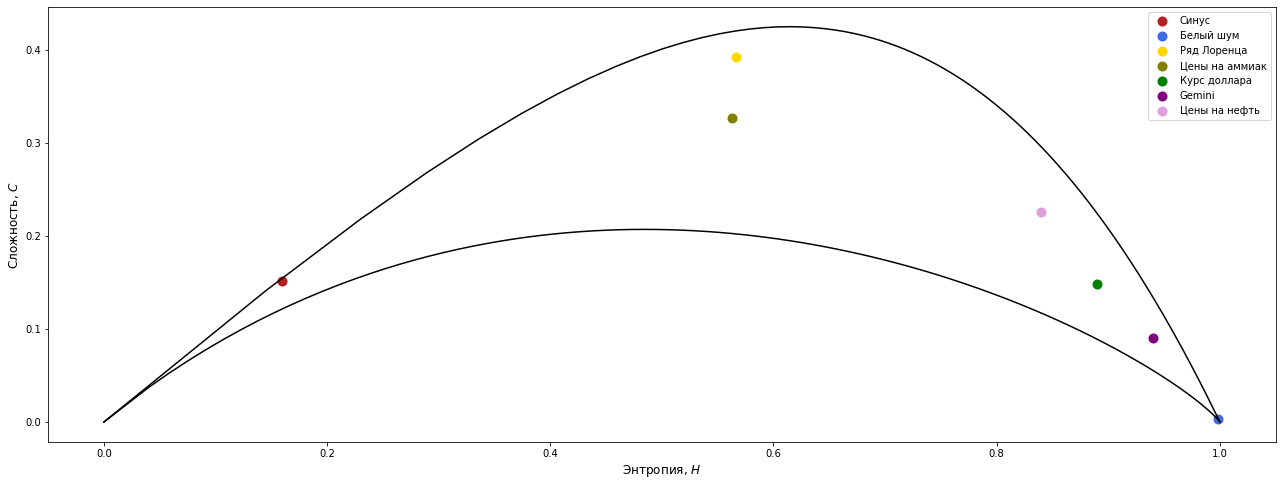

In [40]:
M = 5

min_ec, max_ec = get_borders(m=M)

plt.figure(figsize = (22,8))

plt.plot(max_ec[:,0], max_ec[:,1], color='black')
plt.plot(min_ec[:,0], min_ec[:,1], color='black')

for i in range(0, len(series_list)):
    sd = Series_data(series_list[i])
    H, C_mpr = sd.entropy_complexity(m=M)
    plt.scatter(H, C_mpr, linewidth = 4, label = series_names[i], color = colors[i])
    del sd

plt.xlabel('Энтропия, $H$', fontsize=12)
plt.ylabel('Сложность, $C$', fontsize=12)
#plt.title('Энтропия - Сложность', fontsize = 14)
plt.legend()
plt.show()

#Прогнозирование на основе кластеризации

In [21]:
class Clustering_algorithm:

    def __init__(self, series_data, m=5, sample=[], r=10, h=0.2, delta=0.05, d=1, normalize=1):
        self.normalize = normalize
        if (normalize == 1):
            self.data = series_data # исходный ряд
            self.scaler = MinMaxScaler(feature_range=(0, 1)) # для нормализации ряда
            self.scaler.fit(self.data.reshape((len(self.data), 1)))
            self.y = self.scaler.transform(self.data.reshape((len(self.data), 1))).reshape(-1, len(self.data))[0]
        else:
            self.y = series_data
        self.length = len(self.y)
        if len(sample) == 0:
            self.m = m #размерность z_i
            self.k = [1]*(self.m-1) #по умолчанию шаблон берет последовательные наблюдения
        else:
            self.k = sample # шаблон (размерности m-1)
            self.m = len(sample) + 1
        self.d = d # сдвиг
        self.z_vectors = [] 
        self.dist_matrix = [] # матрица расстояний между z-векторами
        self.r = r # r ближайших соседей
        self.d_list = [] # радиус окрестности с центром в z_i
        self.p_list = [] # значимость вектора z_i
        self.n_clusters = 0 # количество кластеров на текущий момент
        self.is_cluster_ready = [] # сформированность кластера (0\1)
        self.cluster = [] # к какому кластеру относится z_i
        self.h = h # уровень значимости кластера
        self.delta = delta # порог для возможых прогнозных значений

    #Составим набор z-векторов в соответствии с шаблоном k и сдвигом d
    def get_z_vectors(self):
        sum_k = np.sum(self.k)
        z_vec = []
        i = 0
        while i < (self.length - sum_k):
            vec = []
            vec.append(self.y[i])
            cur_sum = 0
            for j in range(0, len(self.k)):
                cur_sum += self.k[j]
                vec.append(self.y[i + cur_sum])
            z_vec.append(np.array(vec))
            i += self.d
        self.z_vectors = z_vec
        #print(self.z_vectors)
    
    #Посчитаем матрицу расстояний между z-векторами
    def get_dist_matrix(self):
        if len(self.z_vectors) == 0:
            self.get_z_vectors()
        s = len(self.z_vectors)
        dist_matrix = np.zeros([s,s])
        for i in range(0, s):
            for j in range(0, s):
                dist_matrix[i][j] = LA.norm(self.z_vectors[i] - self.z_vectors[j])
        self.dist_matrix = dist_matrix
        #print(self.dist_matrix)

    #Посчитаем радиус окрестности и значимость для каждого вектора z_i
    def get_radius_list(self):
        if len(self.dist_matrix) == 0:
            self.get_dist_matrix()
        for z_i in self.dist_matrix:
            ind = np.argsort(z_i)
            rad = z_i[ind[self.r]]
            V = (np.pi)**2 * (rad)**4 / 2
            p = self.r / (V * len(self.z_vectors))
            self.d_list.append(rad)
            self.p_list.append(p)

    def visualize_statistic(self, fig_size = (24, 6)):
        if len(self.d_list) == 0:
            self.get_radius_list()
        # Графики
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
        ax1.plot(np.arange(1, len(self.z_vectors) + 1), self.d_list, color = 'saddlebrown')
        ax1.set_title('Радиус окрестности вектора')
        ax1.set_xlabel('Номер вектора')
        ax1.set_ylabel('Радиус')
        ax2.plot(np.arange(1, len(self.z_vectors) + 1), self.p_list, color = 'saddlebrown')
        ax2.set_title('Значимость вектора')
        ax2.set_xlabel('Номер вектора')
        ax2.set_ylabel('Значимость')
        plt.show()
        
    #Отсортируем набор z-векторов в порядке возрастания d(z_i)
    def get_d_order_index(self):
        if len(self.d_list) == 0:
            self.get_radius_list()
        return np.argsort(self.d_list)

    def init_clusters(self):
        self.cluster = np.array([-1] * len(self.z_vectors))

    # Проверка кластера на значимость
    def significance_check(self, cur_cluster):
        z_in_cluster_list = np.where(self.cluster == cur_cluster)[0] # номера векторов z_i, относящихся к данному кластеру
        res = 0
        if (len(z_in_cluster_list) > 1):
            max_diff = 0
            for pair in list(combinations(z_in_cluster_list, 2)):
                if np.abs(self.p_list[pair[0]] - self.p_list[pair[1]]) > max_diff:
                        max_diff = np.abs(self.p_list[pair[0]] - self.p_list[pair[1]])
            if max_diff >= self.h:
                res = 1
        return res

    def clustering(self):
        ind_sorted = self.get_d_order_index()
        self.init_clusters()

        for i in ind_sorted:
            count_zj = 0
            cl = []
            for j in np.where(self.cluster >  0)[0]: # отбираем все промаркированные z_j
                if (self.dist_matrix[i][j] <= self.d_list[j]): # проверяем, лежит ли z_i в окрестности z_j
                    count_zj += 1
                    cl.append(self.cluster[j])

            if (count_zj == 0):
                # вектор изолирован -> добавляем новый кластер
                self.n_clusters += 1
                self.cluster[i] = self.n_clusters
                self.is_cluster_ready.append(0)
            else:
                # у вектора есть промаркированные соседи
                uniq_cl = np.unique(cl)
                if (len(uniq_cl) == 1):
                    # соседние промаркированные вектора относятся к одному кластеру
                    if (self.is_cluster_ready[uniq_cl[0]-1] == 0):
                        self.cluster[i] = uniq_cl[0] # кластер не сформирован, относим к нему
                    else: 
                        self.cluster[i] = 0 # класс фсормирован -> z_i - шум
                else:
                    # z_i связан с векторами из разных кластеров : cl_1, ..., cl_q
                    alpha_list = [] # список значимых кластеров среди cl_1, ..., cl_q
                    for cl in uniq_cl:
                        if (self.significance_check(cl) == 1):
                            alpha_list.append(cl)
                    if (len(alpha_list) == 0):
                        # z_i не связан ни с одним значимым кластером -> z_i - шум
                        self.cluster[i] = 0
                    elif (len(alpha_list) == 1):
                        # z_i связан только с одним значимым кластером
                        # z_i и все вектора, принадлежащие другим кластерам, относятся к данному
                        self.cluster[i] = alpha_list[0]
                    elif (len(alpha_list) > 1):
                        self.cluster[i] = 0 # z_i - шум
                        # значимые кластеры признаются сформированными
                        for cl in alpha_list:
                            self.is_cluster_ready[cl-1] = 1

    # Визуализируем результаты кластеризации
    def print_clusterisation_info(self, with_noise = 1, display_graph=1, return_value=0, fig_size=(24, 8)):
        if self.n_clusters == 0:
            self.clustering()
        n_formed_clusters = np.sum(self.is_cluster_ready)
        proc_formed_clusters = round(n_formed_clusters / self.n_clusters * 100, 1)
        noise_share = round(np.sum(self.cluster == 0) / len(self.z_vectors) * 100, 1)
        cluster_hist = []
        for cl in range(1, self.n_clusters+1):
            cluster_hist.append(np.sum(self.cluster == cl))
        if (display_graph == 1):
            print('Число кластеров: {n}.'.format(n=self.n_clusters))
            print('Число сформированных кластеров: {sign_n} ({sign_n_proc} %).'.format(sign_n = n_formed_clusters, sign_n_proc = proc_formed_clusters))
            print('Доля векторов, отнесенных к шуму: {noise} %.'.format(noise = noise_share))
            #График
            fig = plt.figure(figsize=fig_size)
            if (with_noise == 1):
                plt.bar([0], [np.sum(self.cluster == 0)], color = 'indianred', label = 'Шум')
            plt.bar(np.arange(1, self.n_clusters+1), cluster_hist, color = 'rosybrown', label = 'Несформированные кластеры')
            plt.bar(np.arange(1, self.n_clusters+1), np.multiply(cluster_hist, self.is_cluster_ready), color = 'steelblue', label = 'Cформированные кластеры')
            plt.title('Распределение векторов по кластерам', fontsize = 12)
            plt.xlabel('Номер кластера')
            plt.ylabel('Количество векторов')
            plt.legend(fontsize = 12)
            plt.show()
        if (return_value == 1):
            return self.n_clusters, n_formed_clusters, noise_share, np.mean(cluster_hist)

    # Находим центры полученных кластеров (среднее по всем z_i в кластере)
    def get_clusters_centrs(self, only_full = 0):
        if self.n_clusters == 0:
            self.clustering()
        if (only_full == 0):
            # Рассматриваются все кластеры (сформированные и не сформированные)
            cluster_list = np.arange(0, self.n_clusters)
        else:
            # Рассматриваются сформированные кластеры
            cluster_list = np.where(self.is_cluster_ready == 1)
        cluster_centers = []
        for cl in cluster_list:
            z_ind = np.where(self.cluster == cl+1)[0]
            z_matrix = [self.z_vectors[i] for i in z_ind] # z-вектора, относящиеся к текущему кластеру
            avg = np.average(z_matrix, axis=0) # среднее значение
            cluster_centers.append(avg)
        return cluster_centers

    def get_cropped_vector(self):
        sum_k = np.sum(self.k[:-1])
        i = self.length - sum_k - 1
        cur_sum = 0
        vec = []
        vec.append(self.y[i])
        for j in range(0, len(self.k[:-1])):
            cur_sum += self.k[j]
            vec.append(self.y[i + cur_sum])
        return vec
    
    # Вычисляет единое прогнозное значение по множеству возможных прогнозных значений
    def get_unified_prediction(self, predictions_set, method, weights_ = []):
        if (method == 'average'):
            return np.mean(predictions_set)
        elif (method == 'weighted average'):
            return np.average(predictions_set, weights=weights_)
        elif (method == 'median'):
            return np.median(predictions_set)
        elif (method == 'most frequent'):
            return np.bincount(predictions_set).argmax()

    # Формируем множество возможных прогнозных значений
    def get_one_step_prediction(self, return_value=1, print_info=0, uni_method = 'average', weights = 0, only_full=0):
        if self.n_clusters == 0:
            self.clustering()
        possible_predictions = []
        if (weights == 1):
            weights_list = []
        last_obs = self.get_cropped_vector()
        centers = self.get_clusters_centrs(only_full=only_full)
        last_ind = len(centers[0]) - 1
        for center in centers:
            if (LA.norm(center[:-1] - last_obs) <= self.delta):
                possible_predictions.append(center[last_ind]) # добавляем последний элемент центра кластера ко множеству возможных прогнозных значений
                if (weights == 1):
                    weights_list.append(1 - LA.norm(center[:-1] - last_obs)/self.delta)

        # Если изначально значения ряда масштабировались, необходимо применить обратные преобразования.
        if (self.normalize == 1 and len(possible_predictions) != 0):
            possible_predictions = self.scaler.inverse_transform(np.array(possible_predictions).reshape(len(possible_predictions), -1))
            possible_predictions = possible_predictions.reshape(1, len(possible_predictions))[0]

        # Находим единое прогнозное значение
        if (len(possible_predictions) != 0):
            if (weights == 1):
                unified_value = round(self.get_unified_prediction(predictions_set=possible_predictions, method=uni_method, weights_=weights_list), 2)
            else:
                unified_value = round(self.get_unified_prediction(predictions_set=possible_predictions, method=uni_method), 2)
        else:
            unified_value = np.nan

        if (print_info == 1):
            if (len(possible_predictions) == 0):
                print('Не найдено ни одного возможного прогнозного значения.')
            else:
                print('Найдено возможных прогнозных значений: {n_set}. Единое прогнозное значение равно {uni_val}.'.format(n_set = len(possible_predictions), uni_val = unified_value))
                
        if (return_value == 1):
            return len(possible_predictions), unified_value

# Сравнение моделей

In [22]:
class model_comparison:

    def __init__(self, data_df):
        # Класс принимает на вход датафрейм с полями ds (дата/индекс), y (прогнозируемое значение). Возможны также другие поля (признаки).
        self.data = data_df
        self.length = self.data.shape[0]
        
    def train_valid_test_split(self, df, train_share = 0.7, valid_share = 0.1, test_share = 0.2, valid = 1):
        if (valid == 1):
            train_size = round(self.length * train_share)
            valid_size = round(self.length * valid_share)
        else:
            train_size = round(self.length * (train_share + valid_share))
            valid_size = 0

        train_df = df.loc[:train_size]
        valid_df = df.loc[train_size+1:train_size+valid_size]
        test_df = df.loc[train_size+valid_size+1:]
        return train_df, valid_df, test_df

    def get_metrics(self, true, pred):
        RMSE = mean_squared_error(true, pred)
        MAPE = mean_absolute_percentage_error(true, pred)
        return RMSE, MAPE

    # Библиотека Prophet
    def Prophet_forecast(self, display_forecast=1, display_components=1, return_value=0, n_steps=-1, fig_size = (24, 8)):
        self.data['ds']= pd.to_datetime(self.data['ds'])
        train_df, valid_df, test_df = self.train_valid_test_split(df=self.data[['ds', 'y']], valid=0)
        if (n_steps == -1):
            n_steps = len(test_df)

        model = Prophet()
        model.fit(train_df)

        forecast = pd.DataFrame(test_df['ds'][:n_steps])
        forecast['ds']= pd.to_datetime(forecast['ds'])
        pred_prophet = model.predict(forecast)

        rmse, mape = self.get_metrics(test_df.y.values[:n_steps], pred_prophet.yhat.values)

        if (display_forecast == 1):
            print('RMSE = ', rmse)
            print('MAPE = ', mape, '\n')
            plt.figure(figsize = fig_size)
            plt.plot(train_df.ds, train_df.y,  color = 'steelblue', linewidth = 1, label= 'Обучающая выборка')
            plt.plot(test_df.ds, test_df.y, color = 'goldenrod', linewidth = 1, label= 'Тестовая выборка')
            plt.plot(np.concatenate((train_df.ds[-1:], pred_prophet.ds), axis=None), np.concatenate((train_df.y[-1:], pred_prophet.yhat), axis=None), 
                     color = 'black', linewidth = 1, label= 'Прогноз Facebook Prophet')
            plt.legend()
            plt.show()
        if (display_components == 1):
            model.plot_components(pred_prophet, figsize = fig_size) # Посмотрим отдельно на компоненты: тренд, годовую и недельную сезонность.
        if (return_value == 1):
            return pred_prophet, rmse, mape
        
    # Библиотека ETNA
    def Etna_forecast(self, freq_, model_, fig_size = (24, 8)):
        self.data['ds']= pd.to_datetime(self.data['ds'])
        data_for_etna = self.data
        data_for_etna.rename({"ds":"timestamp", "y":"target"}, axis='columns', inplace = True)
        data_for_etna["segment"] = ["main"] * data_for_etna.shape[0]

        df = TSDataset.to_dataset(data_for_etna)
        ts = TSDataset(df, freq = freq_)

        train_ts, test_ts = ts.train_test_split(train_start=ts.describe()['start_timestamp']['main'],
                                        train_end="2016-12-31",
                                        test_start="2017-01-01",
                                        test_end=ts.describe()['end_timestamp']['main'])
        
        transforms = [
            # удаляем выбросы из данных
            #DensityOutliersTransform(
            #    in_column="target",
            #    window_size=45,
            #    n_neighbors=25,
            #    distance_coef=1.9
            #),
            # заполняем образовавшиеся пропуски
            TimeSeriesImputerTransform(
                in_column="target",
                strategy="running_mean"
            ),
            # вычитаем тренд
            #LinearTrendTransform(in_column="target"),
        ]

        model = model_
        pipeline = Pipeline(
            model=model,
            transforms=transforms,
            horizon=test_ts.describe()['length']['main']
        )
        pipeline.fit(train_ts)
        forecast_ts = pipeline.forecast()
        plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=0, figsize=fig_size)
            
    # Прогнозирование на основе кластеризации
    def clusterization_based_algorithm(self, display_forecast=1, return_value=0,
                                       m=5, sample=[], r=10, h=0.2, delta=0.05, d=1, normalize=1, 
                                       one_value_method = 'average', w_=0, f_=0,
                                       n_steps = -1, last_train = -1, fig_size=(24, 8)):
        if (len(sample) == 0):
            sample = [1]*(m-1)
        else:
            m = len(sample)+1
        train_df, valid_df, test_df = self.train_valid_test_split(df = self.data[['ds', 'y']], valid=0)
        if (n_steps == -1):
            n_steps = test_df.shape[0]
        
        _ser = train_df['y'].values
        forecast = []
        unpredict_points = 0
        for step in range(0, n_steps):
            model = Clustering_algorithm(series_data=_ser, m=m, sample=sample, r=r, h=h, delta=delta, d=d, normalize=normalize)
            pred_size, pred_val = model.get_one_step_prediction(return_value=1, print_info=0, uni_method=one_value_method, weights=w_, only_full=f_)
            forecast.append(pred_val)
            if (pred_size != 0):
                 _ser = np.append(_ser, pred_val)
            else:
                _ser = np.append(_ser, 0)
                sample[len(sample)-1] += 1
                unpredict_points += 1
            del model

        if (unpredict_points == 0):
            rmse, mape = self.get_metrics(test_df.y.values[:n_steps], forecast)
        else:
            tr = train_df['y'].shape[0]
            rmse, mape = self.get_metrics(test_df.y.values[:n_steps], _ser[tr:])

        if (display_forecast == 1):
            plt.figure(figsize = fig_size)
            if (last_train == -1):
                plt.plot(train_df.ds, train_df.y, 
                     color = 'steelblue', linewidth = 1, label= 'Обучающая выборка')
            else:
                plt.plot(train_df.ds[-last_train:], train_df.y[-last_train:], 
                     color = 'steelblue', linewidth = 1, label= 'Последние {n} наблюдений обучающей выборки'.format(n=last_train)) 
            plt.plot(np.concatenate((train_df.ds[-1:], test_df.ds[:n_steps]), axis=None), np.concatenate((train_df.y[-1:], test_df.y[:n_steps]), axis=None), 
                     color = 'goldenrod', linewidth = 1, label= 'Тестовая выборка')
            plt.plot(np.concatenate((train_df.ds[-1:], test_df.ds[:n_steps]), axis=None), np.concatenate((train_df.y[-1:], forecast), axis=None), 
                     color = 'red', linewidth = 1, label= 'Прогноз на основе кластеризации')
            plt.legend()
            plt.show() 
            print('Число непрогнозируемых точек = {n}'.format(n=unpredict_points))
        if (return_value == 1):
            return forecast, rmse, mape, unpredict_points

    def compare(self, model_list = ['Прогноз на основе кластеризации', 'Прогноз Facebook Prophet'], return_metrics=1, display_forecast=1, fig_size = (24,8),
                                       m=5, sample=[], r=10, h=0.2, delta=0.05, d=1, normalize=1,
                                        one_value_= 'average', w_=0, f_=0, n_steps = -1, last_train = -1):
        train_df, valid_df, test_df = self.train_valid_test_split(df = self.data[['ds', 'y']], valid=0)
        if (n_steps == -1):
            n_steps = test_df.shape[0]
        
        if (display_forecast == 1):
            plt.figure(figsize = fig_size)
            if (last_train == -1):
                plt.plot(train_df.ds, train_df.y, 
                        color = 'steelblue', linewidth = 1, label= 'Обучающая выборка')
            else:
                plt.plot(train_df.ds[-last_train:], train_df.y[-last_train:], 
                        color = 'steelblue', linewidth = 1, label= 'Последние {n} наблюдений обучающей выборки'.format(n=last_train))
            plt.plot(np.concatenate((train_df.ds[-1:], test_df.ds[:n_steps]), axis=None), np.concatenate((train_df.y[-1:], test_df.y[:n_steps]), axis=None), 
                        color = 'goldenrod', linewidth = 1, label= 'Тестовая выборка')
        
        metrics = pd.DataFrame(index=model_list, columns = ['RMSE', 'MAPE', 'Число непрогнозируемых точек', 'Время исполнения, мин.'])

        for mod in model_list:
            if (mod == 'Прогноз на основе кластеризации'):
                start = time.time()
                forecast, rmse, mape, unpredict_points = self.clusterization_based_algorithm(display_forecast=0, return_value=1,
                                       m=m, sample=sample, r=r, h=h, delta=delta, d=d, normalize=normalize, n_steps = n_steps, last_train = last_train, one_value_method=one_value_, w_=w_, f_=f_)
                if (display_forecast == 1):
                    plt.plot(np.concatenate((train_df.ds[-1:], test_df.ds[:n_steps]), axis=None), np.concatenate((train_df.y[-1:], forecast), axis=None), 
                         color = 'red', linewidth = 1, label= 'Прогноз на основе кластеризации')

                metrics.loc['Прогноз на основе кластеризации', 'RMSE'] =  round(rmse, 2)
                metrics.loc['Прогноз на основе кластеризации', 'MAPE'] =  round(mape, 2)
                metrics.loc['Прогноз на основе кластеризации', 'Число непрогнозируемых точек'] = unpredict_points
                metrics.loc['Прогноз на основе кластеризации', 'Время исполнения, мин.'] = round((time.time() - start)/60, 2)
                
            elif(mod == 'Прогноз Facebook Prophet'):
                start = time.time()
                forecast, rmse, mape = self.Prophet_forecast(display_forecast=0, display_components=0, return_value=1, n_steps=n_steps)
                if (display_forecast == 1):
                    plt.plot(np.concatenate((train_df.ds[-1:], forecast.ds), axis=None), np.concatenate((train_df.y[-1:], forecast.yhat), axis=None), 
                         color = 'black', linewidth = 1, label= 'Прогноз Facebook Prophet')

                metrics.loc['Прогноз Facebook Prophet', 'RMSE'] =  round(rmse, 2)
                metrics.loc['Прогноз Facebook Prophet', 'MAPE'] =  round(mape, 2)
                metrics.loc['Прогноз Facebook Prophet', 'Время исполнения, мин.'] = round((time.time() - start)/60, 2)

        if (display_forecast == 1):
            plt.title('Построение прогноза на {s} шагов вперед'.format(s=n_steps))
            plt.legend()
            plt.show()
        if (return_metrics == 1):
            return metrics

#Данные

In [23]:
def one_step_prediction_visualize(data, prediction_value, last_train = 20, fig_size= (20, 6)):
    l = len(data)
    plt.figure(figsize = fig_size)
    plt.plot(np.arange(l-last_train, l, 1), data[-last_train:], color = 'steelblue', linewidth = 2, label= 'Ряд')
    plt.scatter([l-1], data[-1:], color = 'darkblue', linewidth = 3, label= 'Фактическое значение')
    plt.plot([l-2, l-1], np.concatenate((data[-2:-1], [prediction_value]), axis=None), color = 'red', linewidth = 2)
    plt.scatter([l-1], [prediction_value], color = 'red', linewidth = 3, label= 'Прогноз')
    plt.plot([l-2, l-1], np.concatenate((data[-2:-1], [prediction_value]), axis=None), color = 'red', linewidth = 2)
    plt.legend()
    plt.show()

In [24]:
def n_steps(data, n_steps_list = [5, 10, 15], last_train = 30, fig_size= (24, 6)):
     rmse_list = []
     mape_list = []
     unpred_points = []
     for n in n_steps_list:
         model = model_comparison(data)
         forecast, rmse, mape, points = model.clusterization_based_algorithm(display_forecast=0, return_value=1, 
                                                                       m=8, n_steps=n, last_train=last_train)
         rmse_list.append(rmse)
         mape_list.append(mape)
         unpred_points.append(points)

         del model

     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=fig_size)
     ax1.plot(n_steps_list, rmse_list, color = 'lightblue', linewidth = 2)
     ax1.scatter(n_steps_list, rmse_list, color = 'lightblue', linewidth = 2)
     ax1.set_title('Зависимость RMSE от Г.П.')
     ax1.set_xlabel('Кол-во шагов')
     ax1.set_ylabel('RMSE')
     ax2.plot(n_steps_list, mape_list, color = 'slategrey', linewidth = 2)
     ax2.scatter(n_steps_list, mape_list, color = 'slategrey', linewidth = 2)
     ax2.set_title('Зависимость MAPE от Г.П.')
     ax2.set_xlabel('Кол-во шагов')
     ax2.set_ylabel('MAPE')
     ax3.plot(n_steps_list, unpred_points, color = 'indianred', linewidth = 2)
     ax3.scatter(n_steps_list, unpred_points, color = 'indianred', linewidth = 2)
     ax3.set_title('Зависимость кол-ва непрогнозируемых точек от Г.П.')
     ax3.set_xlabel('Кол-во шагов')
     ax3.set_ylabel('Кол-во точек')
     plt.show()

In [25]:
def parametr_m(data, m_param = [5, 8, 10], n_=10, last_train = 30, fig_size= (24, 6)):
     rmse_list = []
     mape_list = []
     unpred_points = []
     for m_ in m_param:
         model = model_comparison(data)
         forecast, rmse, mape, points = model.clusterization_based_algorithm(display_forecast=0, return_value=1, 
                                                                       m=m_, n_steps=n_, last_train=last_train)
         rmse_list.append(rmse)
         mape_list.append(mape)
         unpred_points.append(points)

         del model

     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=fig_size)
     ax1.plot(m_param, rmse_list, color = 'lightblue', linewidth = 2)
     ax1.scatter(m_param, rmse_list, color = 'lightblue', linewidth = 2)
     ax1.set_title('Зависимость RMSE от m')
     ax1.set_xlabel('m')
     ax1.set_ylabel('RMSE')
     ax2.plot( m_param, mape_list, color = 'slategrey', linewidth = 2)
     ax2.scatter(m_param, mape_list, color = 'slategrey', linewidth = 2)
     ax2.set_title('Зависимость MAPE от m')
     ax2.set_xlabel('m')
     ax2.set_ylabel('MAPE')
     ax3.plot(m_param, unpred_points, color = 'indianred', linewidth = 2)
     ax3.scatter(m_param, unpred_points, color = 'indianred', linewidth = 2)
     ax3.set_title('Зависимость кол-ва непрогнозируемых точек от m')
     ax3.set_xlabel('m')
     ax3.set_ylabel('Кол-во точек')
     plt.show()

## Ряд Лоренца

In [48]:
f = open('/content/gdrive/My Drive/lorenz.txt', 'r')
lorentz_series = np.array([float(line.strip()) for line in f])[20000:25000]
f.close()

In [49]:
lorentz = Series_data(lorentz_series, np.arange(20000, 25000))

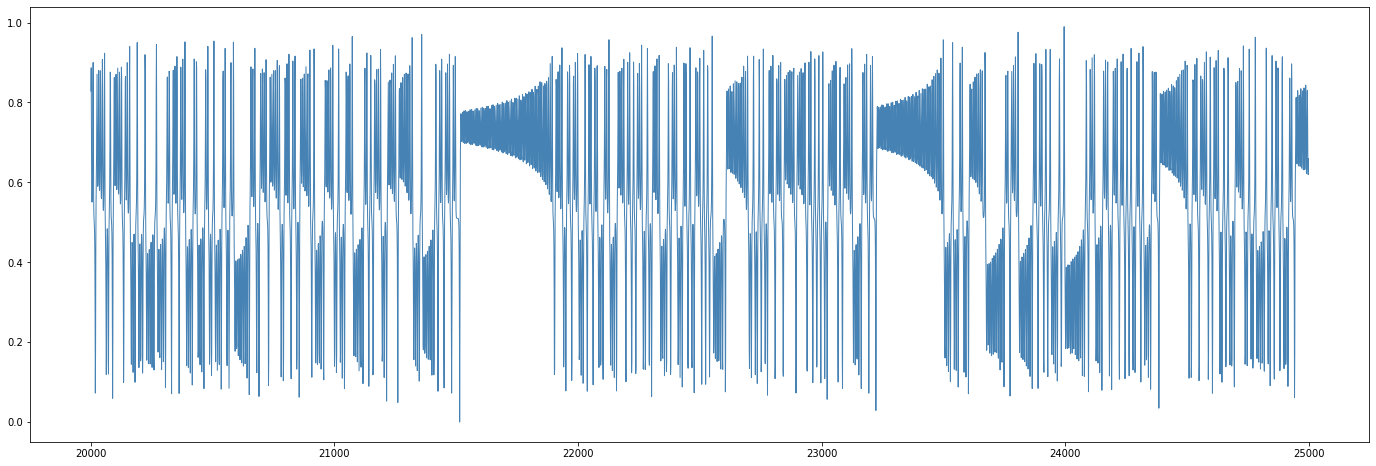

In [50]:
lorentz.get_visualization()

### Прогноз на один шаг вперед

In [51]:
lorentz_clustering = Clustering_algorithm(series_data=lorentz_series[:-1], normalize=0, r = 8, m = 10)

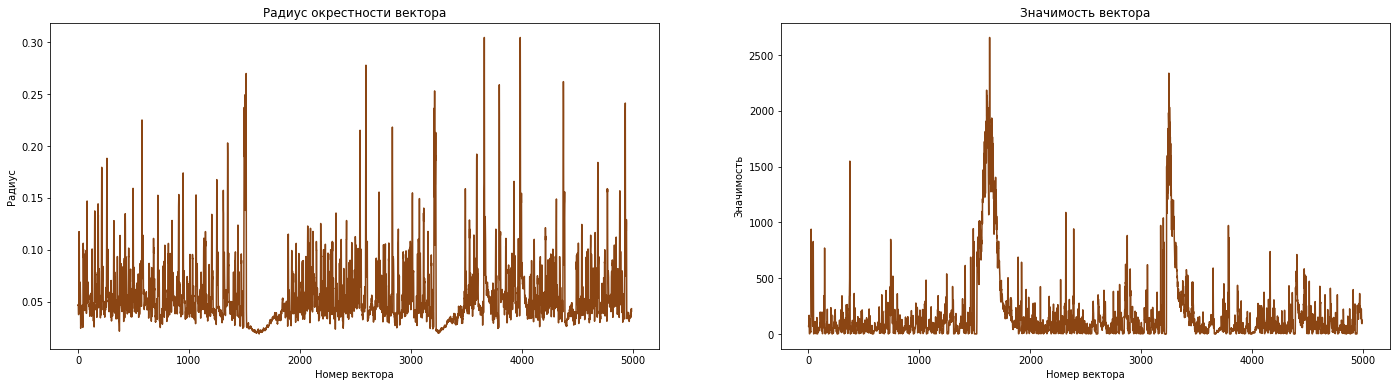

In [52]:
lorentz_clustering.visualize_statistic()

Число кластеров: 585.
Число сформированных кластеров: 352 (60.2 %).
Доля векторов, отнесенных к шуму: 44.4 %.


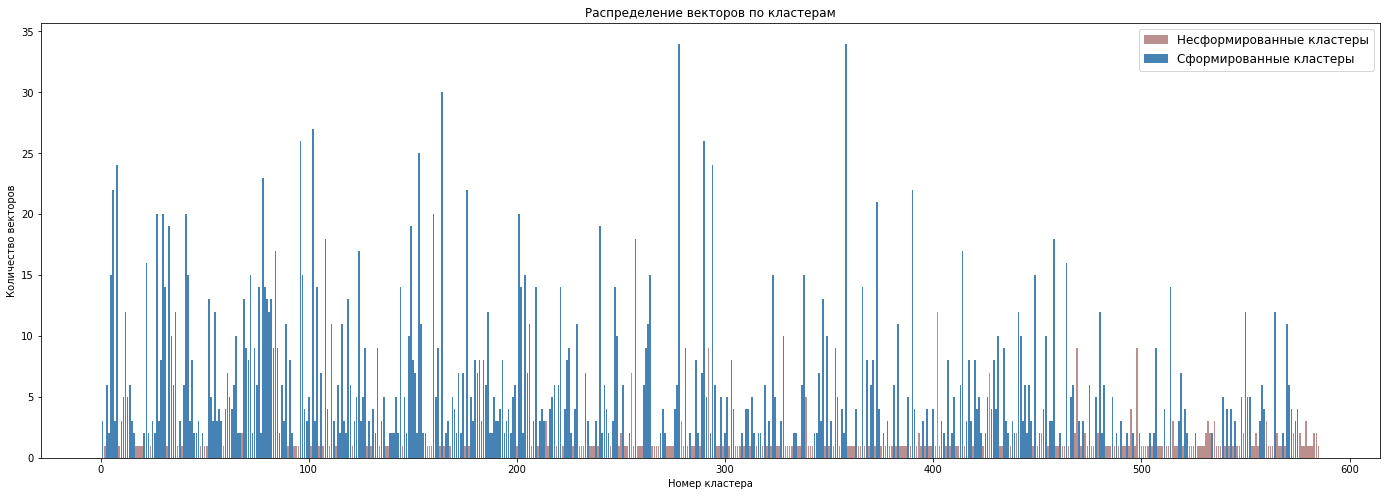

In [53]:
lorentz_clustering.print_clusterisation_info(with_noise=0, fig_size = (24, 8))

In [54]:
# Прогноз на один шаг вперед
set_size_0, pred_val_0 = lorentz_clustering.get_one_step_prediction(print_info=0)

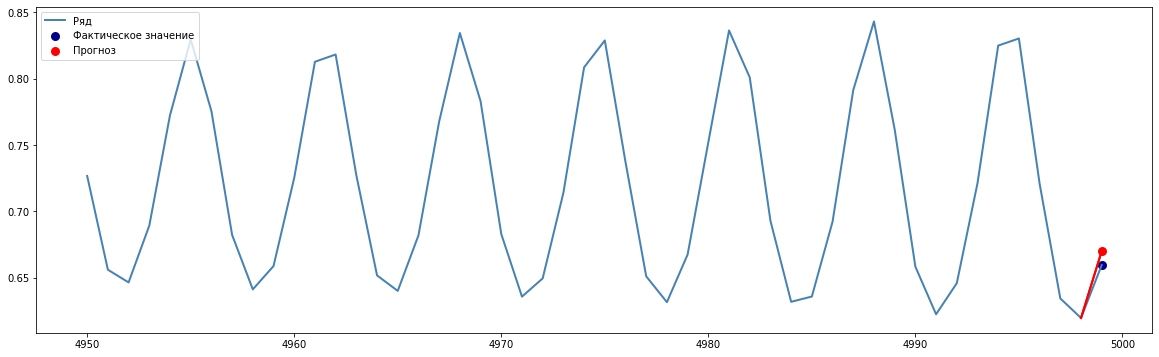

In [55]:
one_step_prediction_visualize(lorentz_series, pred_val_0, last_train = 50)

### Прогноз на несколько шагов вперед

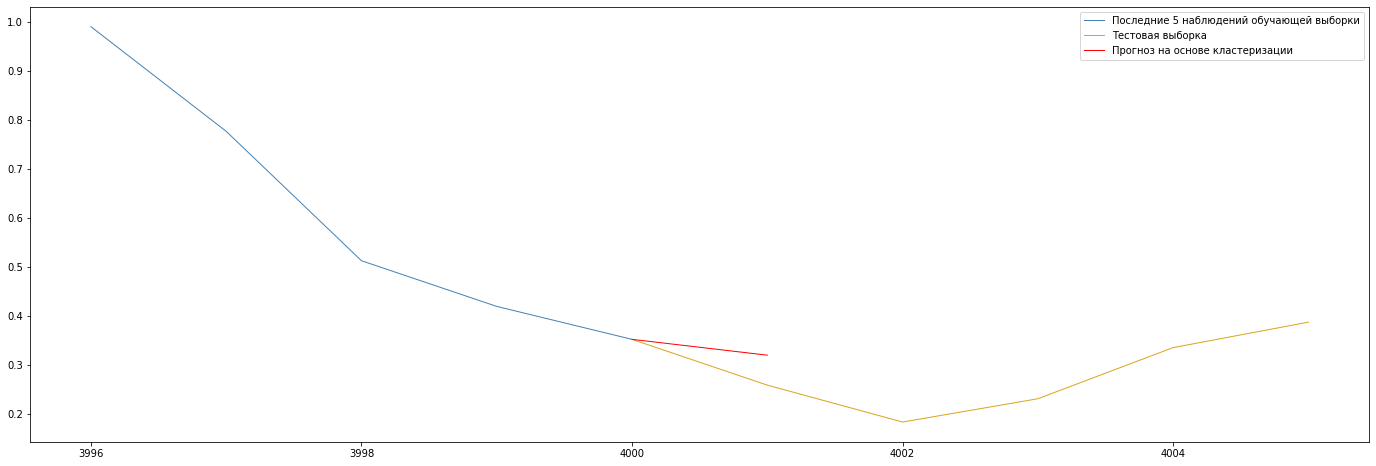

Число непрогнозируемых точек = 4


In [60]:
lorentz_data = pd.DataFrame(columns = ['ds', 'y'])
lorentz_data['ds'] = np.arange(0, len(lorentz_series))
lorentz_data['y'] = lorentz_series

lorentz_model = model_comparison(lorentz_data)

lorentz_model.clusterization_based_algorithm(display_forecast=1, normalize=0, r= 8, m=10, delta=0.1, n_steps=5, last_train = 5)

## Ряд 1

In [16]:
ammonia_data = pd.read_csv('/content/gdrive/My Drive/vkr_data/ammonia_spot_prices.csv')

### Характеристики

In [17]:
ammonia_series = Series_data(ammonia_data['value'].values)

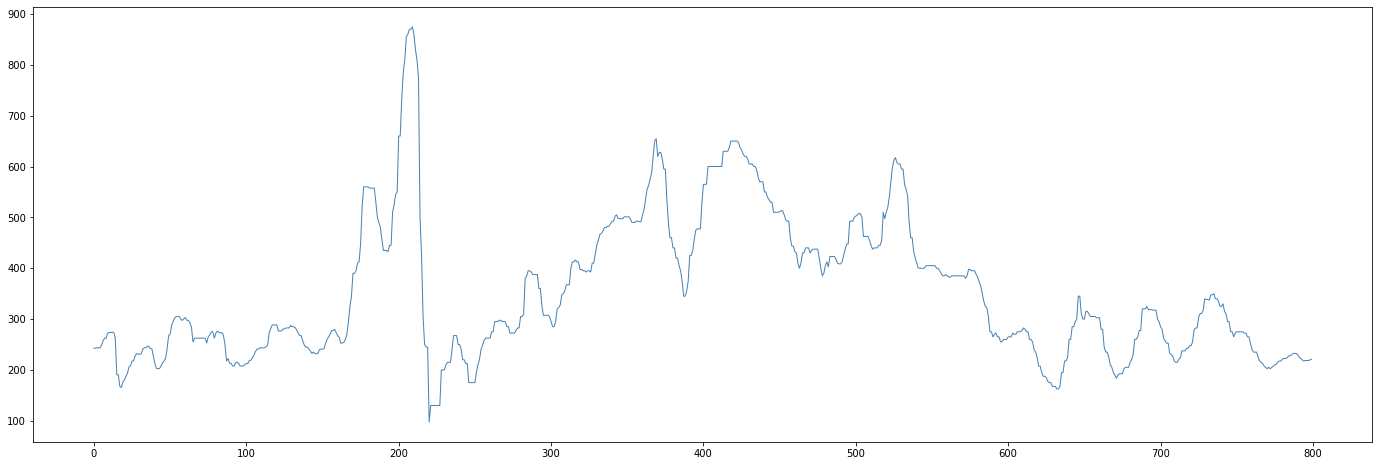

In [18]:
ammonia_series.get_visualization()

ADF-тест: The series is not stationary.
KPSS-тест: The series is not stationary.


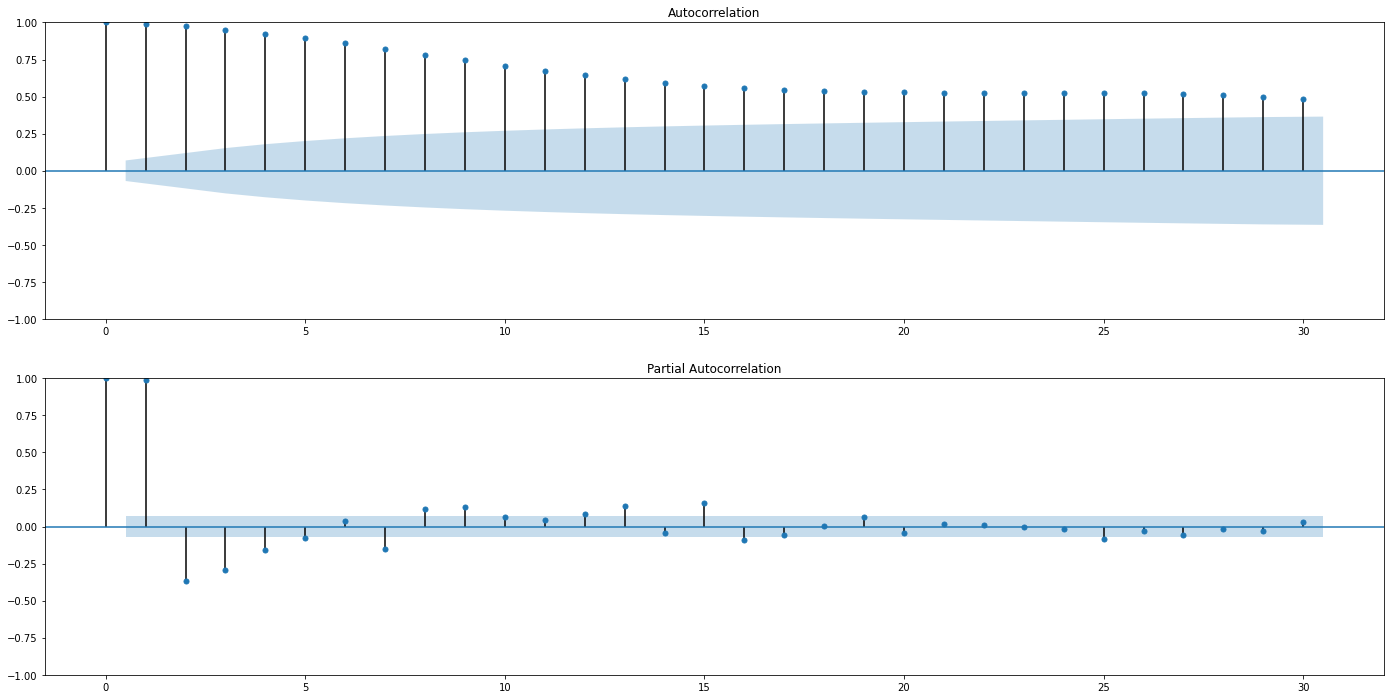

In [19]:
ammonia_series.stationarity_test(lev = 0.05, fig_size=(24, 12))

### Построение прогноза на один шаг вперед



In [65]:
ammonia_clustering = Clustering_algorithm(series_data=ammonia_data['value'].values[:-1], m = 8)

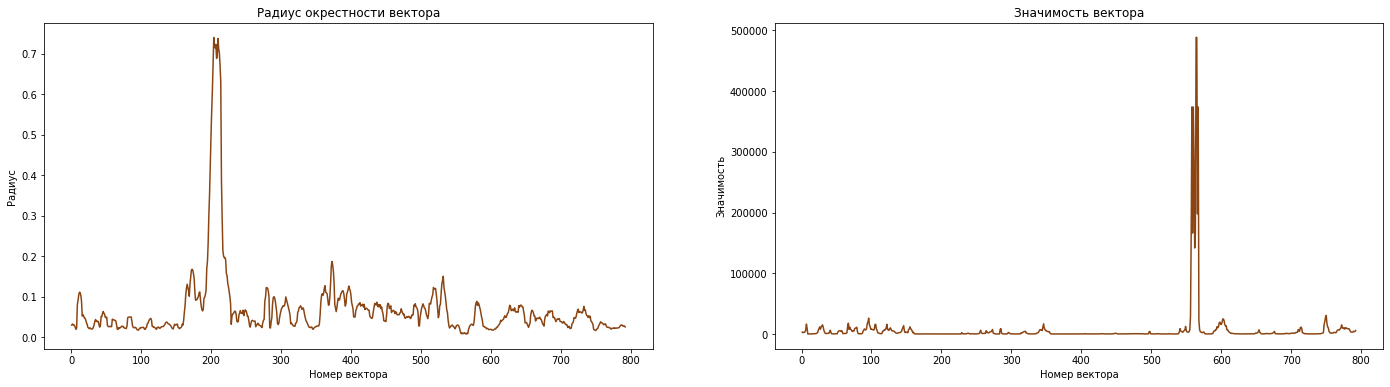

In [66]:
ammonia_clustering.visualize_statistic()

Число кластеров: 94.
Число сформированных кластеров: 42 (44.7 %).
Доля векторов, отнесенных к шуму: 32.4 %.


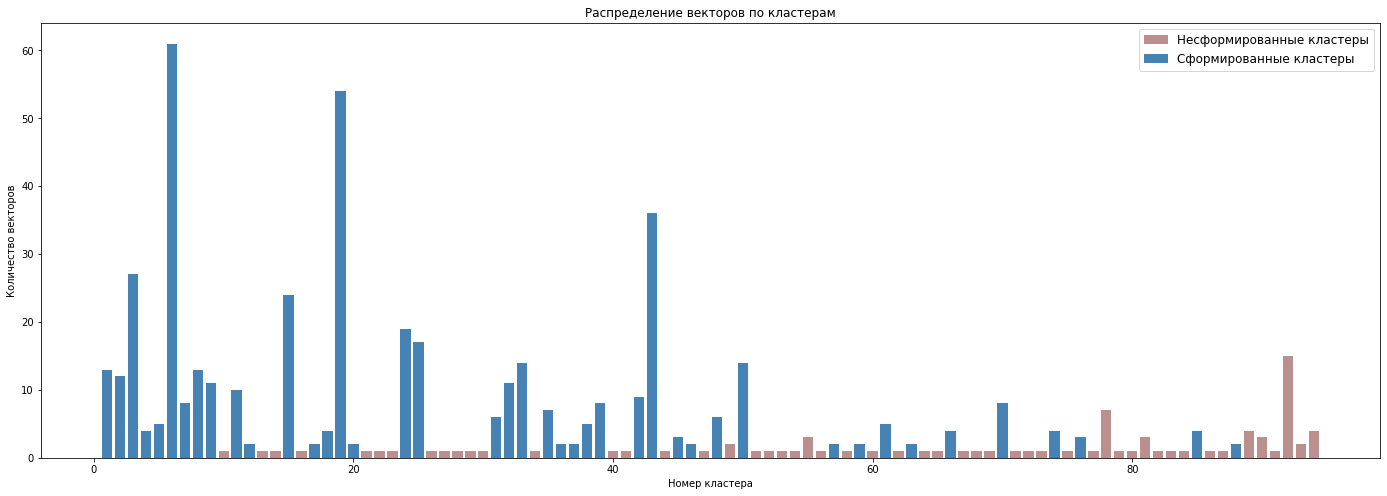

In [67]:
ammonia_clustering.print_clusterisation_info(with_noise=0)

In [68]:
# Прогноз на один шаг вперед
set_size_1,  pred_val_1  = ammonia_clustering.get_one_step_prediction(print_info=1)

Найдено возможных прогнозных значений: 6. Единое прогнозное значение равно 222.25.


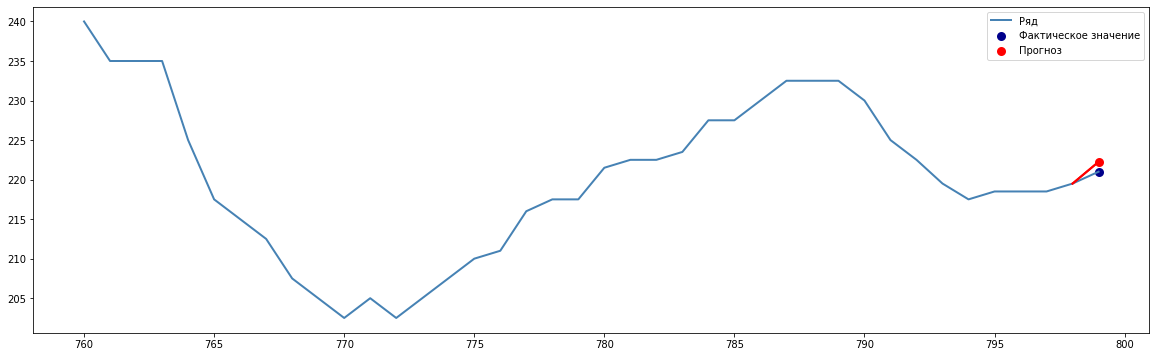

In [69]:
one_step_prediction_visualize(ammonia_data['value'].values, pred_val_1, last_train = 40)

### Параметры

In [ ]:
ammonia_data.columns = ['ds', 'y']

m_param = [4, 6, 8, 10]
parametr_m(ammonia_data, m_param, n_= 5)

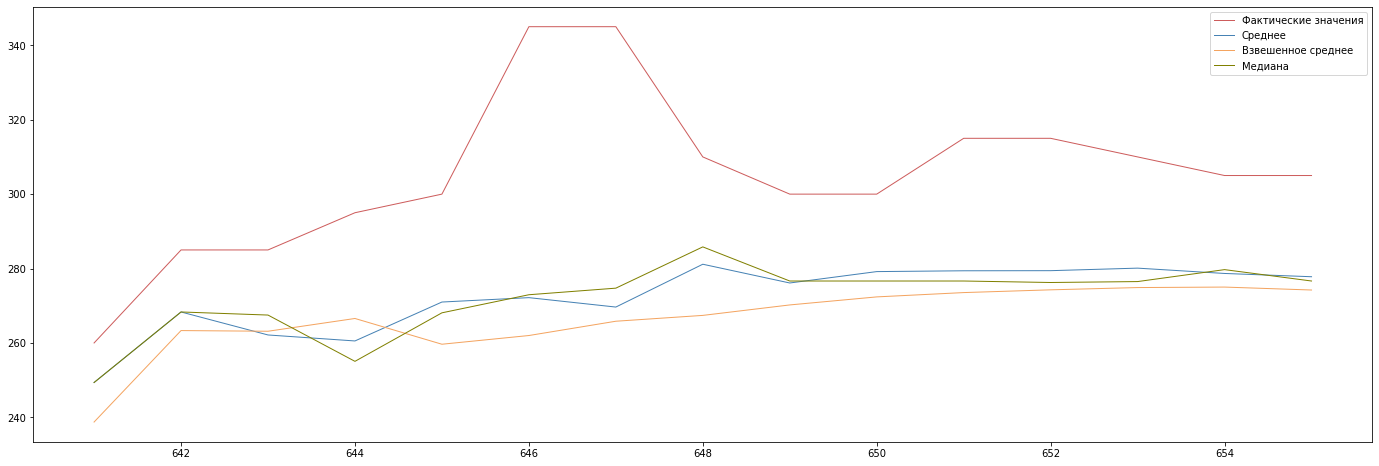

In [47]:
plt.figure(figsize = (24, 8))
n_= 15

ammonia_model_1 = model_comparison(ammonia_data)

tr, val, tst = ammonia_model_1.train_valid_test_split(df=ammonia_data, valid=0)
plt.plot(tst[:n_].index, tst[:n_].y.values, color = 'indianred', linewidth = 1, label = 'Фактические значения') 

forecast1, rmse1, mape1, unpredict_points1 = ammonia_model_1.clusterization_based_algorithm(display_forecast=0, return_value=1, m=10, delta=0.1, n_steps=n_, last_train = 5, 
                                                                      one_value_method='average')
plt.plot(tst[:n_].index, forecast1, color = 'steelblue', linewidth = 1, label = 'Среднее')

ammonia_model_2 = model_comparison(ammonia_data)
forecast2, rmse2, mape2, unpredict_points2 = ammonia_model_2.clusterization_based_algorithm(display_forecast=0, return_value=1, m=10, delta=0.1, n_steps=n_, last_train = 5, 
                                                                      one_value_method='weighted average', w_=1)
plt.plot(tst[:n_].index, forecast2, color = 'sandybrown', linewidth = 1, label = 'Взвешенное среднее')


ammonia_model_3 = model_comparison(ammonia_data)
forecast3, rmse3, mape3, unpredict_points3 = ammonia_model_2.clusterization_based_algorithm(display_forecast=0, return_value=1, m=10, delta=0.1, n_steps=n_, last_train = 5, 
                                                                      one_value_method='median')   
plt.plot(tst[:n_].index, forecast3, color = 'olive', linewidth = 1, label = 'Медиана')
plt.legend()
plt.show()     

In [48]:
metrics_uni = pd.DataFrame(index = ['average', 'weighted average', 'median'], columns = ['RMSE', 'MAPE'])
metrics_uni.loc['average', 'RMSE'] = rmse1
metrics_uni.loc['average', 'MAPE'] = mape1
metrics_uni.loc['weighted average', 'RMSE'] = rmse2
metrics_uni.loc['weighted average', 'MAPE'] = mape2
metrics_uni.loc['median', 'RMSE'] = rmse3
metrics_uni.loc['median', 'MAPE'] = mape3

In [49]:
metrics_uni

,RMSE,MAPE
average,1374.395107,0.104158
weighted average,1793.857853,0.122488
median,1376.70286,0.105157


### Построение прогноза на несколько шагов вперед

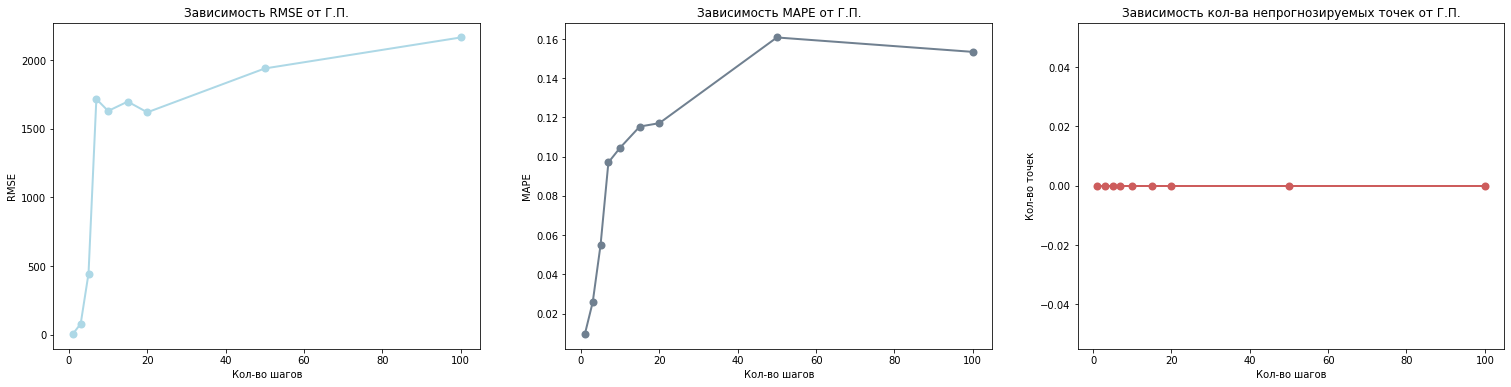

In [114]:
ammonia_data.columns = ['ds', 'y']

n_steps(ammonia_data, [1, 3, 5, 7, 10, 15, 20, 50, 100])

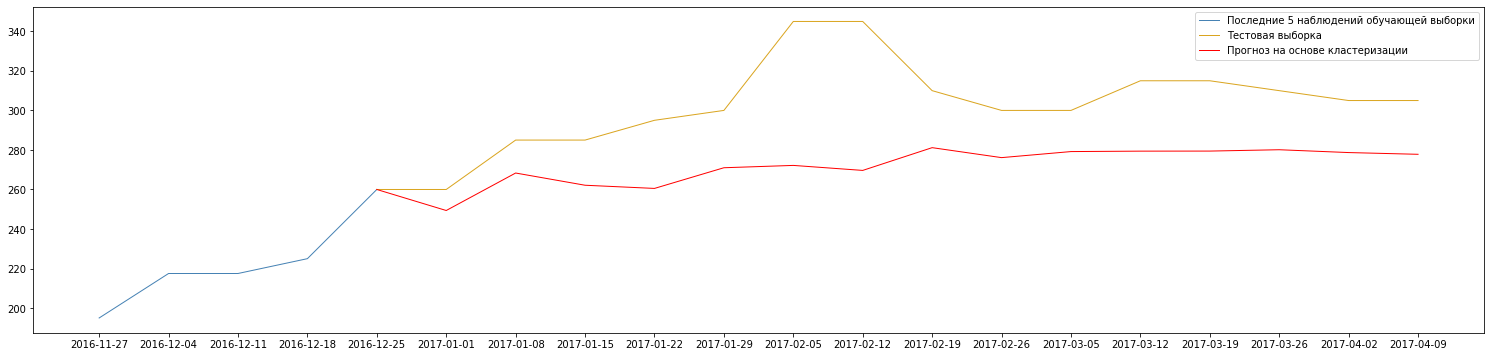

Число непрогнозируемых точек = 0


In [125]:
#Построение прогноза на 15 шагов вперед

#ammonia_data.columns = ['ds', 'y'] 

ammonia_model = model_comparison(ammonia_data)
ammonia_model.clusterization_based_algorithm(display_forecast=1, m=10, delta=0.1, n_steps=15, last_train = 5)


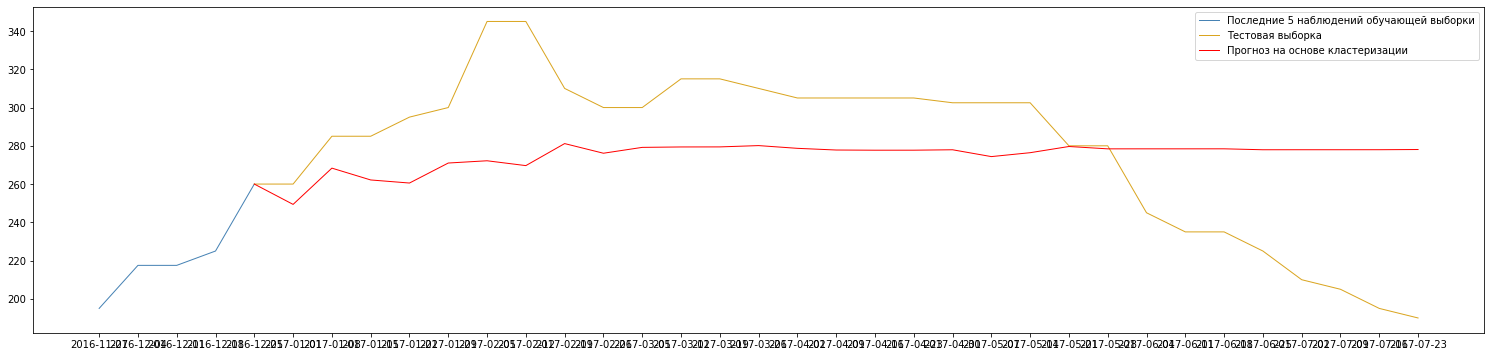

Число непрогнозируемых точек = 0


In [126]:
#Построение прогноза на 30 шагов вперед

ammonia_model = model_comparison(ammonia_data)
ammonia_model.clusterization_based_algorithm(display_forecast=1, m=10, delta=0.1, n_steps=30, last_train = 5)

### Сравнение моделей

In [50]:
#ammonia_data.columns = ['ds', 'y']

ammonia_model = model_comparison(ammonia_data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE =  31465.687051722798
MAPE =  0.6172105724606554 



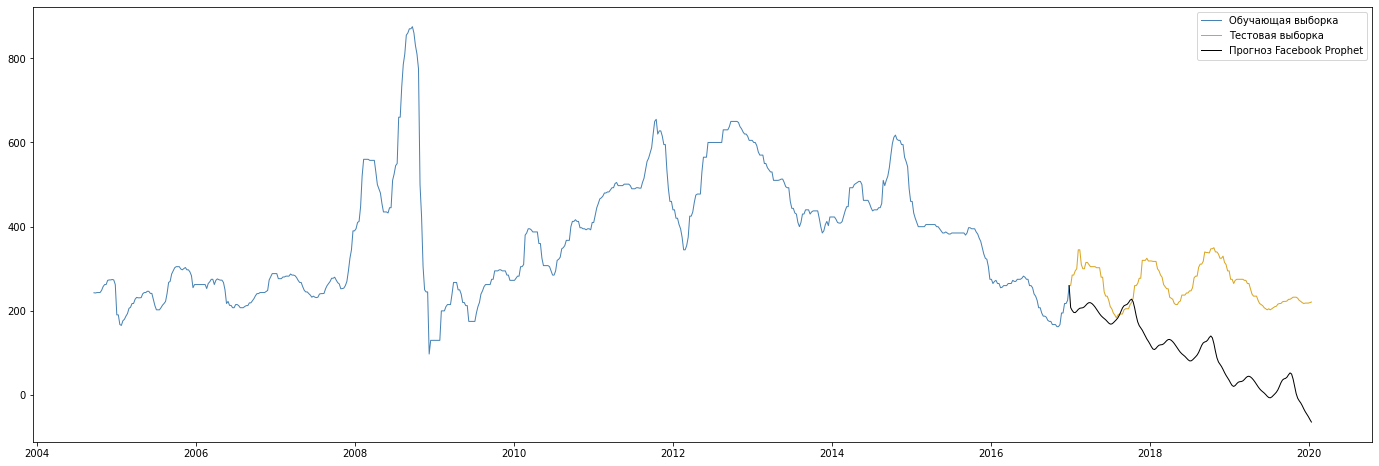

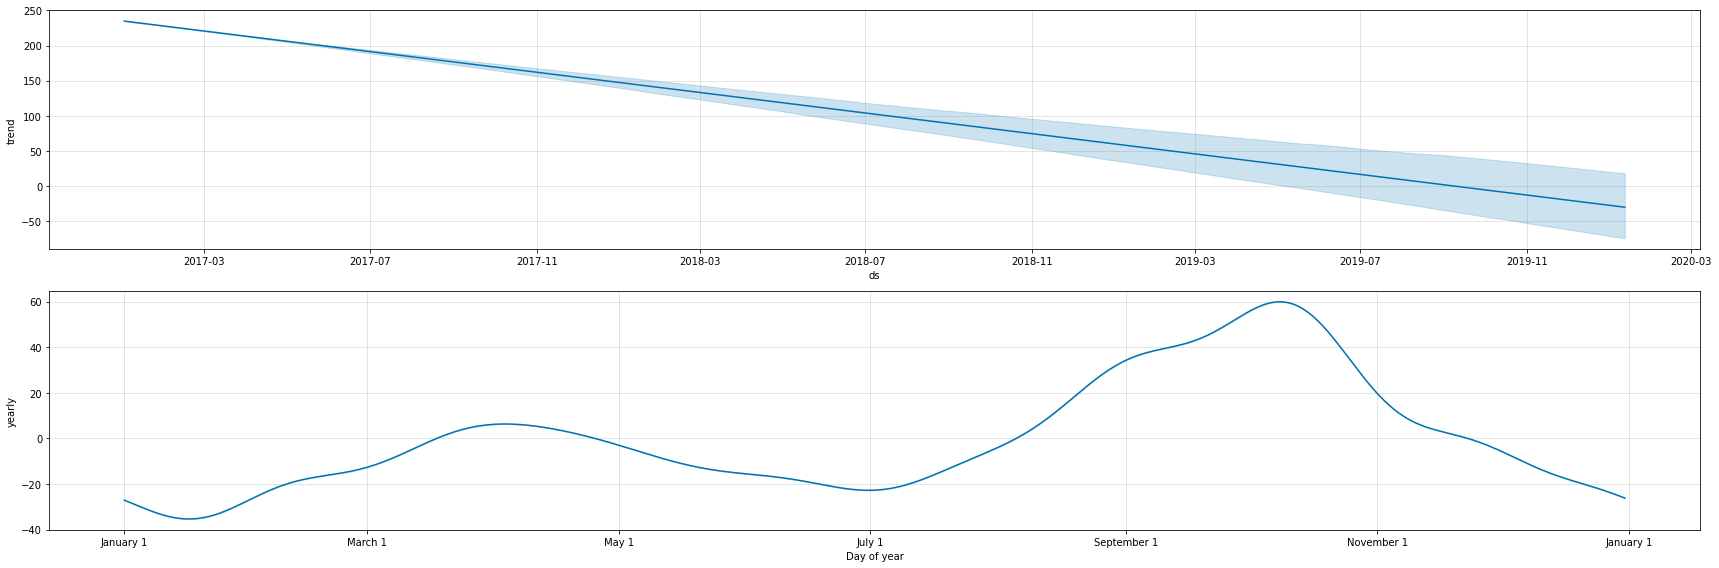

In [51]:
ammonia_model.Prophet_forecast()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


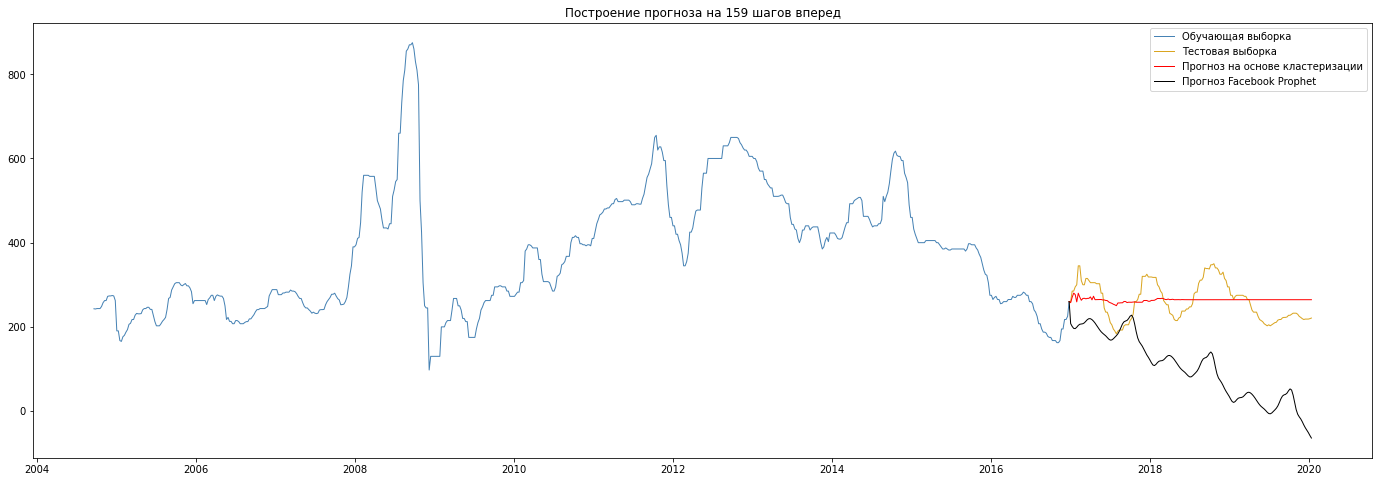

In [ ]:
#Построение прогноза на всей тестовой выборке

ammonia_metrics = ammonia_model.compare(m=8)

In [ ]:
ammonia_metrics

,RMSE,MAPE,Число непрогнозируемых точек,"Время исполнения, мин."
Прогноз на основе кластеризации,1955.9,0.15,0,9.34
Прогноз Facebook Prophet,31465.69,0.62,NaN,0.03


## Ряд 2

In [60]:
exchange_data = pd.read_excel('/content/gdrive/My Drive/vkr_data/Exchange rate dollar.xlsx')[['data', 'curs']][1996:]
exchange_data.sort_values(by='data', inplace = True)
exchange_data.reset_index(inplace = True, drop = True)

### Характеристика

In [53]:
exchange_ser = Series_data(exchange_data.curs, exchange_data.data)

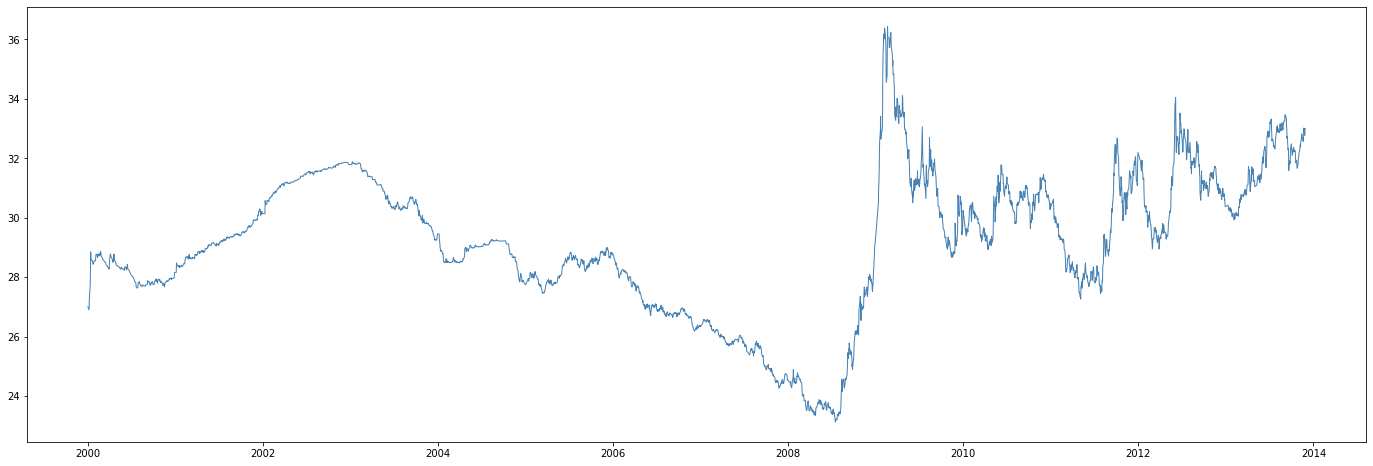

In [54]:
exchange_ser.get_visualization()

ADF-тест: The series is not stationary.
KPSS-тест: The series is not stationary.


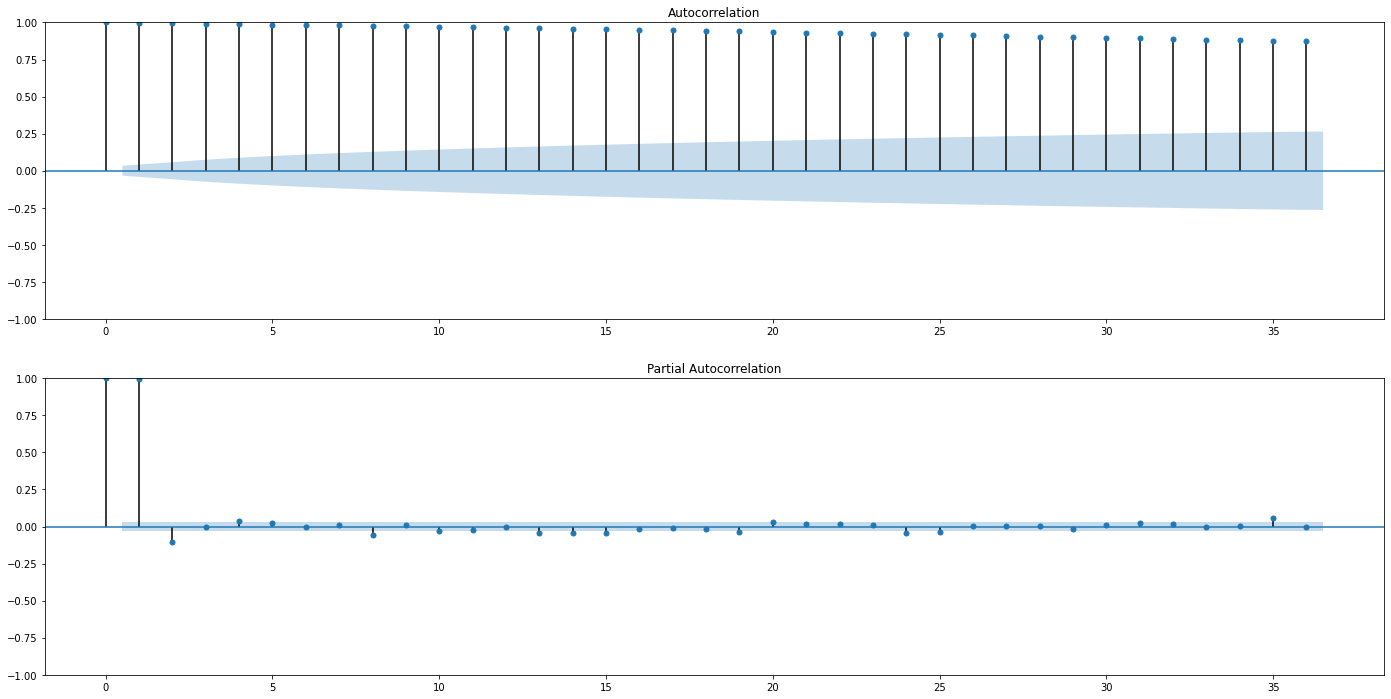

In [56]:
exchange_ser.stationarity_test(lev = 0.05, fig_size=(24, 12))

### Построение прогноза на один шаг вперед

In [61]:
exchange_clustering = Clustering_algorithm(series_data=exchange_data.curs.values[:-1], m = 8)

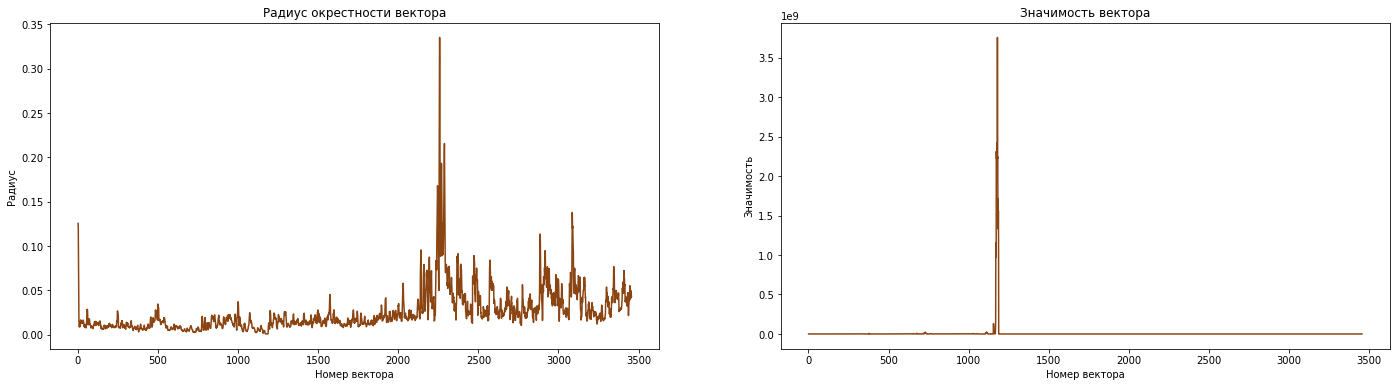

In [62]:
exchange_clustering.visualize_statistic()

Число кластеров: 735.
Число сформированных кластеров: 232 (31.6 %).
Доля векторов, отнесенных к шуму: 31.7 %.


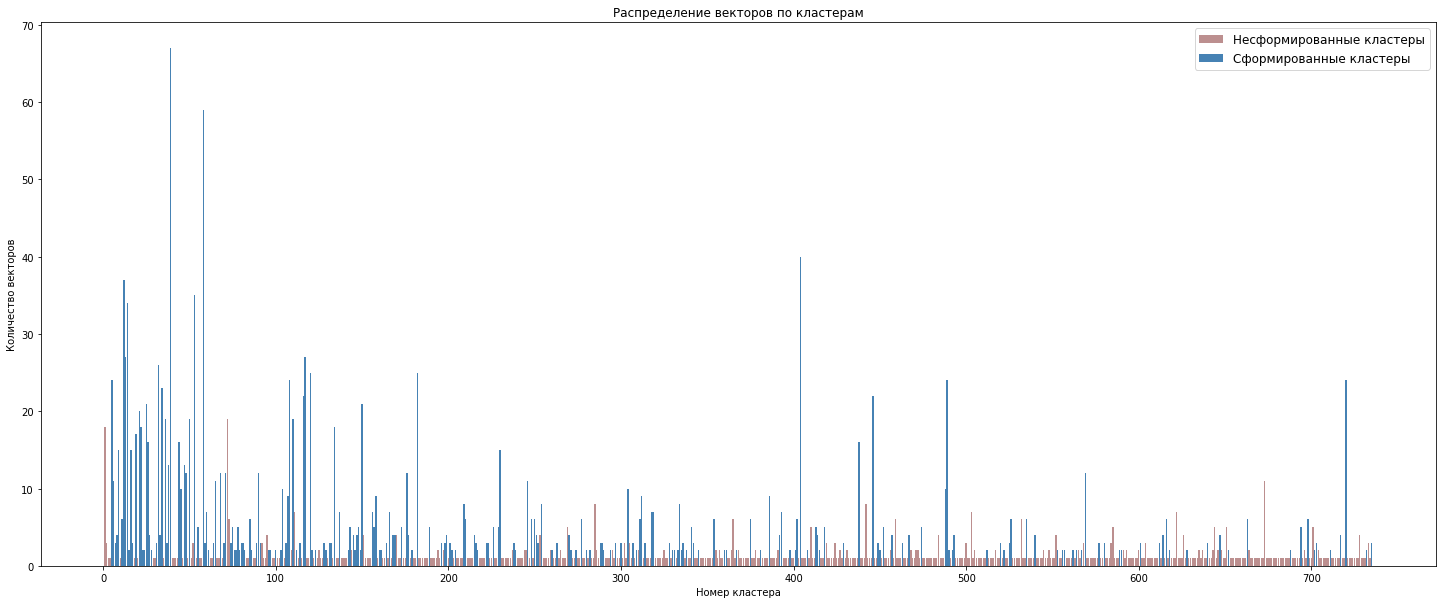

In [63]:
exchange_clustering.print_clusterisation_info(with_noise=0, fig_size=(25, 10))

In [64]:
set_size_2, pred_val_2 = exchange_clustering.get_one_step_prediction(print_info=1)

Найдено возможных прогнозных значений: 4. Единое прогнозное значение равно 32.89.


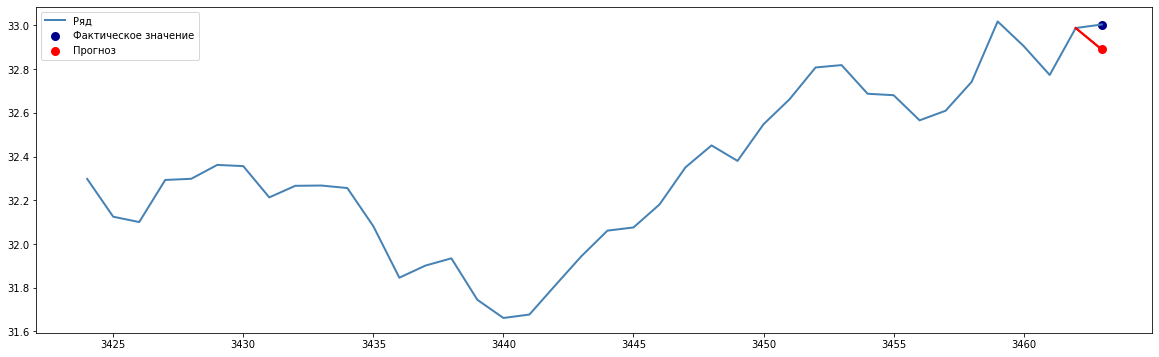

In [65]:
one_step_prediction_visualize(exchange_data['curs'].values, pred_val_2, last_train = 40)

### Параметры

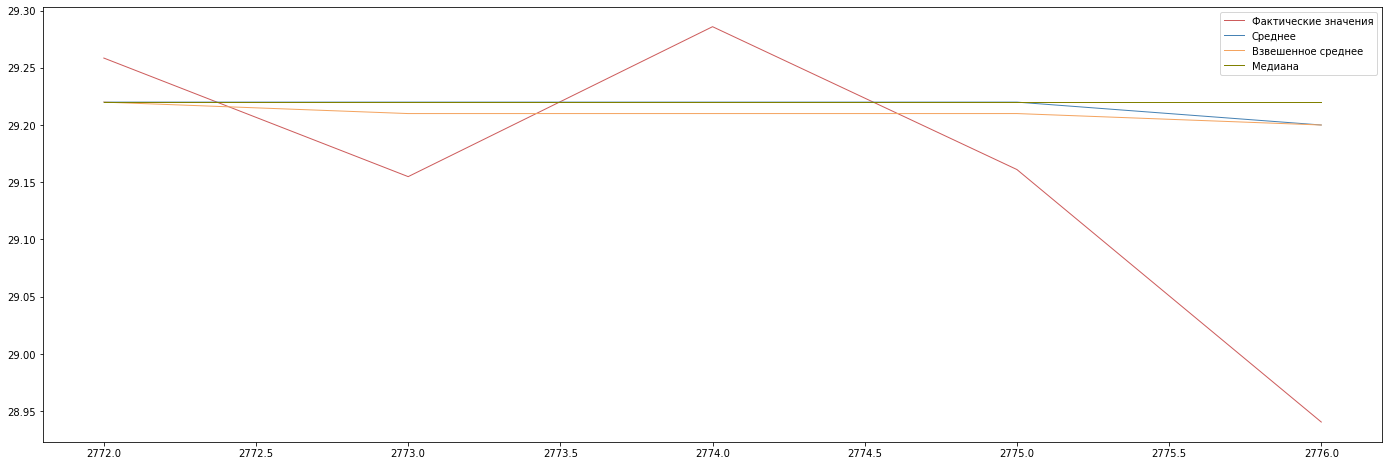

In [58]:
plt.figure(figsize = (24, 8))
n_= 5

exchange_data.columns = ['ds', 'y']

exchange_model_1 = model_comparison(exchange_data)

tr, val, tst = exchange_model_1.train_valid_test_split(df=exchange_data, valid=0)
plt.plot(tst[:n_].index, tst[:n_].y.values, color = 'indianred', linewidth = 1, label = 'Фактические значения') 

forecast1, rmse1, mape1, unpredict_points1 = exchange_model_1.clusterization_based_algorithm(display_forecast=0, return_value=1, m=10, delta=0.1, n_steps=n_, last_train = 5, 
                                                                      one_value_method='average')
plt.plot(tst[:n_].index, forecast1, color = 'steelblue', linewidth = 1, label = 'Среднее')

exchange_model_2 = model_comparison(exchange_data)
forecast2, rmse2, mape2, unpredict_points2 = exchange_model_2.clusterization_based_algorithm(display_forecast=0, return_value=1, m=10, delta=0.1, n_steps=n_, last_train = 5, 
                                                                      one_value_method='weighted average', w_=1)
plt.plot(tst[:n_].index, forecast2, color = 'sandybrown', linewidth = 1, label = 'Взвешенное среднее')


exchange_model_3 = model_comparison(exchange_data)
forecast3, rmse3, mape3, unpredict_points3 = exchange_model_2.clusterization_based_algorithm(display_forecast=0, return_value=1, m=10, delta=0.1, n_steps=n_, last_train = 5, 
                                                                      one_value_method='median')   
plt.plot(tst[:n_].index, forecast3, color = 'olive', linewidth = 1, label = 'Медиана')
plt.legend()
plt.show()   

### Прогноз на несколько шагов вперед

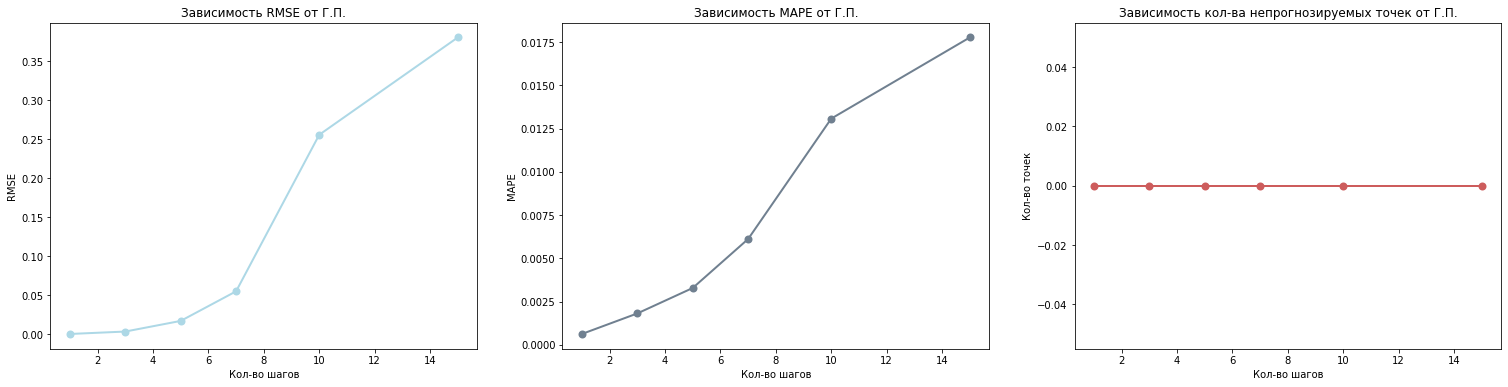

In [116]:
exchange_data.columns = ['ds', 'y']

n_steps(exchange_data, [1, 3, 5, 7, 10, 15])

In [66]:
exchange_data.columns = ['ds', 'y']
exchange_model =  model_comparison(data_df=exchange_data)

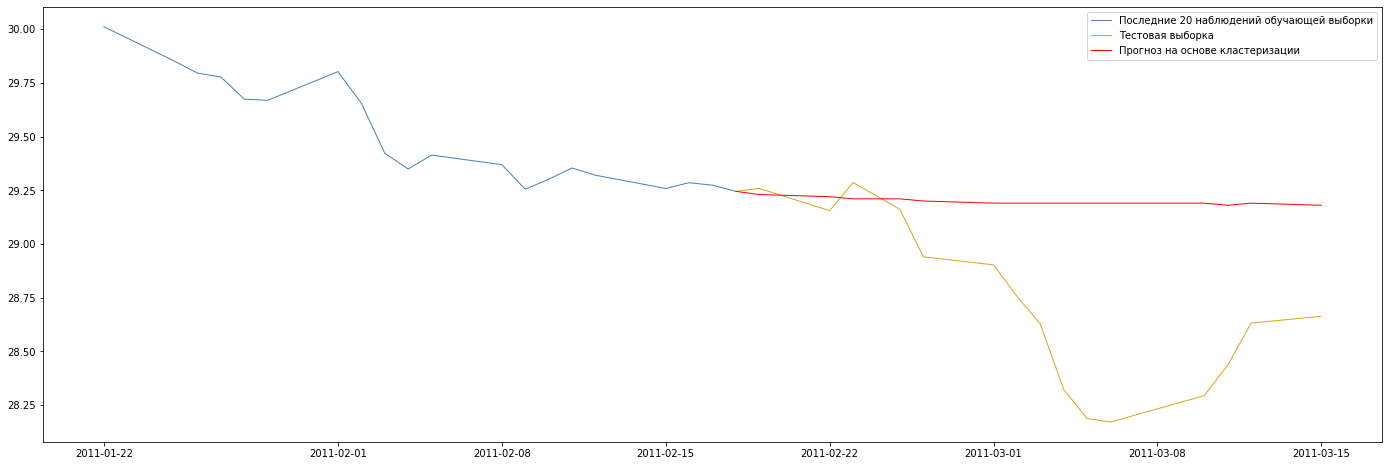

Число непрогнозируемых точек = 0


In [67]:
exchange_model.clusterization_based_algorithm(display_forecast=1, normalize=1, m=6, n_steps=15, one_value_method='weighted average', w_=1, last_train=20)

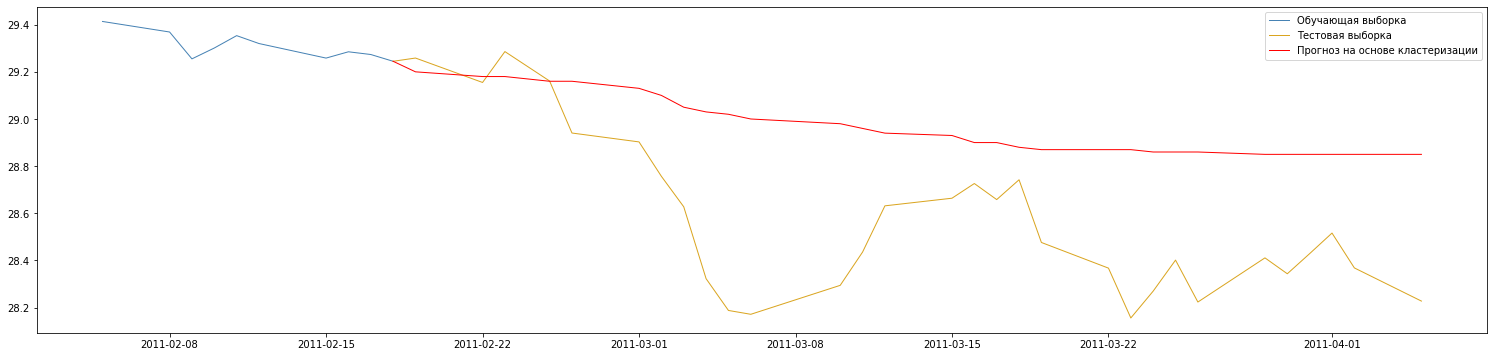

Число непрогнозируемых точек = 0


In [ ]:
exchange_model.clusterization_based_algorithm(display_forecast=1, normalize=1, m=10, delta = 0.15, n_steps=30)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


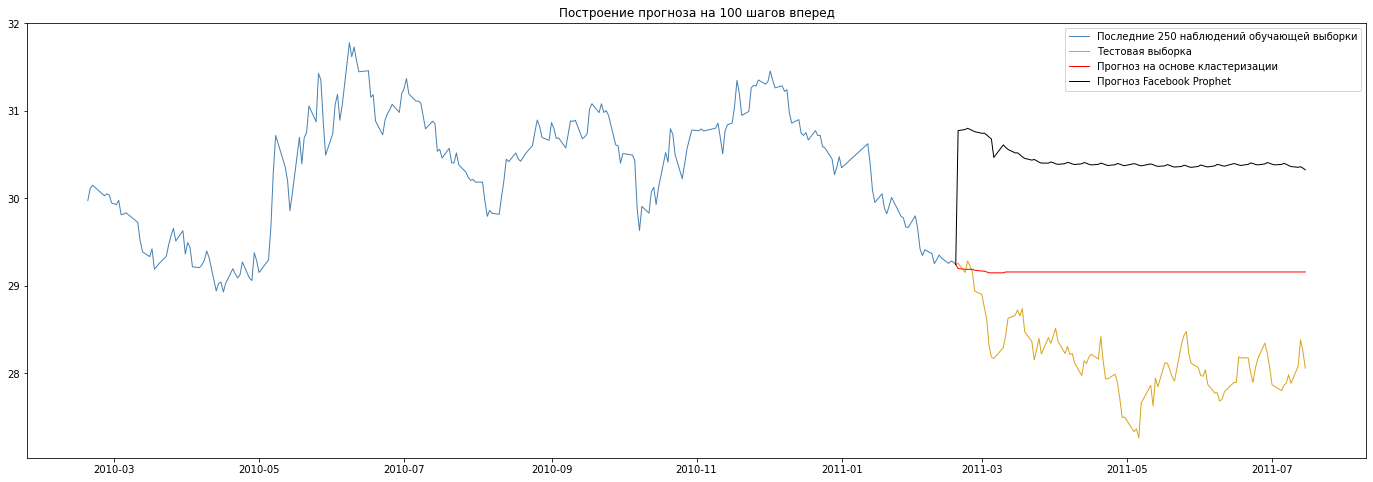

In [ ]:
exchange_metrics = exchange_model.compare(m=10, last_train=250, n_steps=100)

## Ряд 3

In [68]:
gemini_data = pd.read_csv('/content/gdrive/My Drive/vkr_data/gemini.csv', sep = ',')
gemini_data.drop('Unnamed: 0', axis = 1, inplace = True)
gemini_data.head(5)

,date,best ask,best bid,mid price,signal,month,day,am/pm,hour
0,2020-01-01 12:06:04 AM,7155.23,7070.00,7112.615,0,1,1,AM,12
1,2020-01-01 01:25:42 AM,7173.37,7083.49,7128.430,1,1,1,AM,1
2,2020-01-01 02:26:12 AM,7207.32,7099.47,7153.395,1,1,1,AM,2
3,2020-01-01 02:35:22 AM,7219.04,7100.00,7159.520,1,1,1,AM,2
4,2020-01-01 02:45:43 AM,7220.02,7101.00,7160.510,1,1,1,AM,2


### Характеристики

In [69]:
gemini = Series_data(gemini_data['mid price'].values)

In [70]:
gemini.print_info()

Кол-во наблюдений:  11574
Минимальное значение:  3973.47
Максимальное значение:  10357.7
Среднее значение:  8155.58


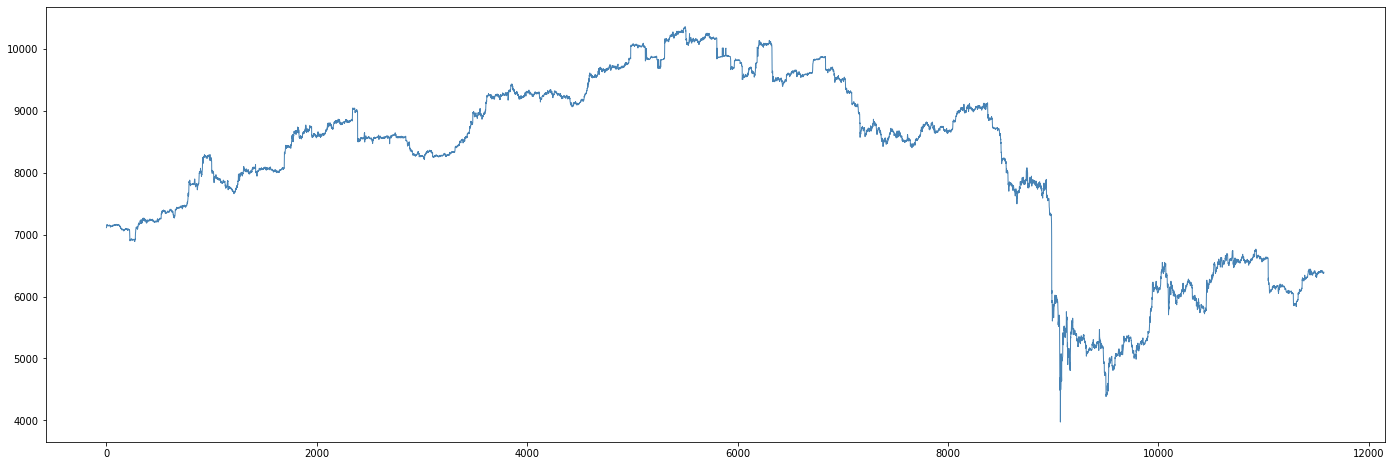

In [71]:
gemini.get_visualization()

ADF-тест: The series is not stationary.
KPSS-тест: The series is not stationary.


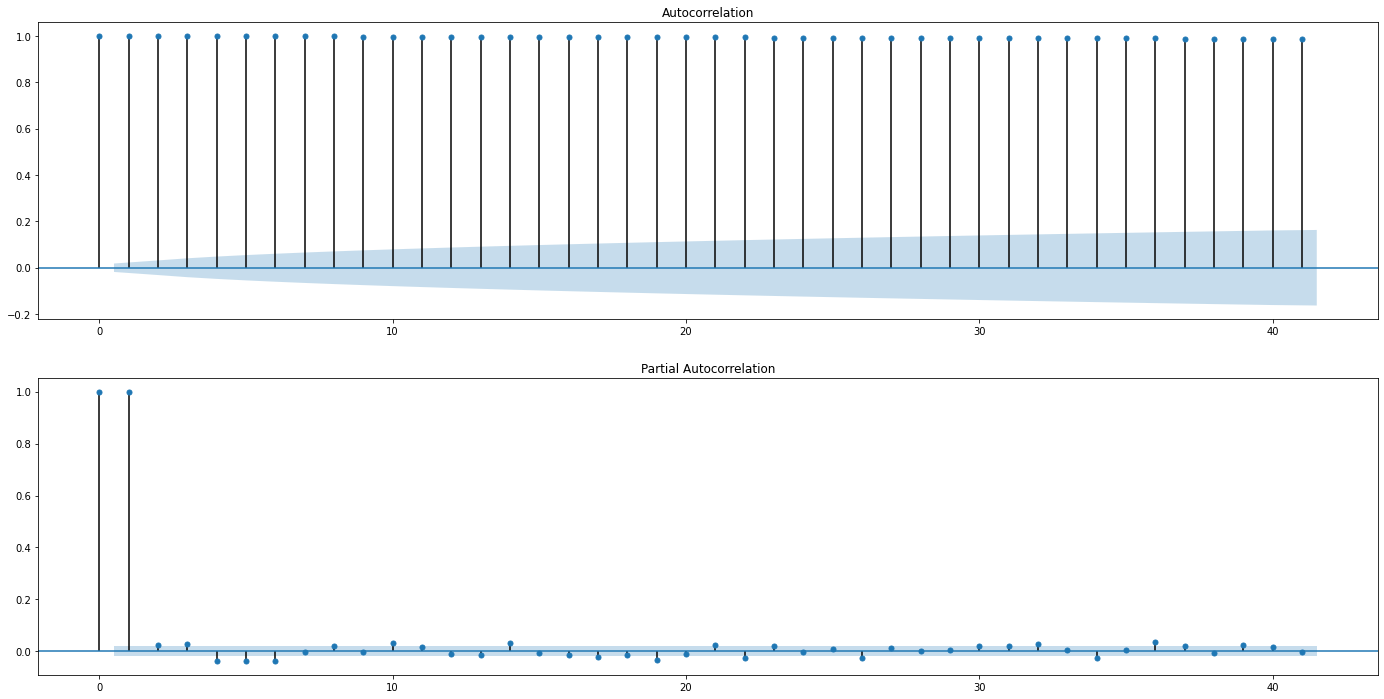

In [ ]:
gemini.stationarity_test(lev = 0.05)

### Построение прогноза на один шаг вперед

In [95]:
gemini_clustering = Clustering_algorithm(series_data=gemini_data['mid price'].values[:-1])

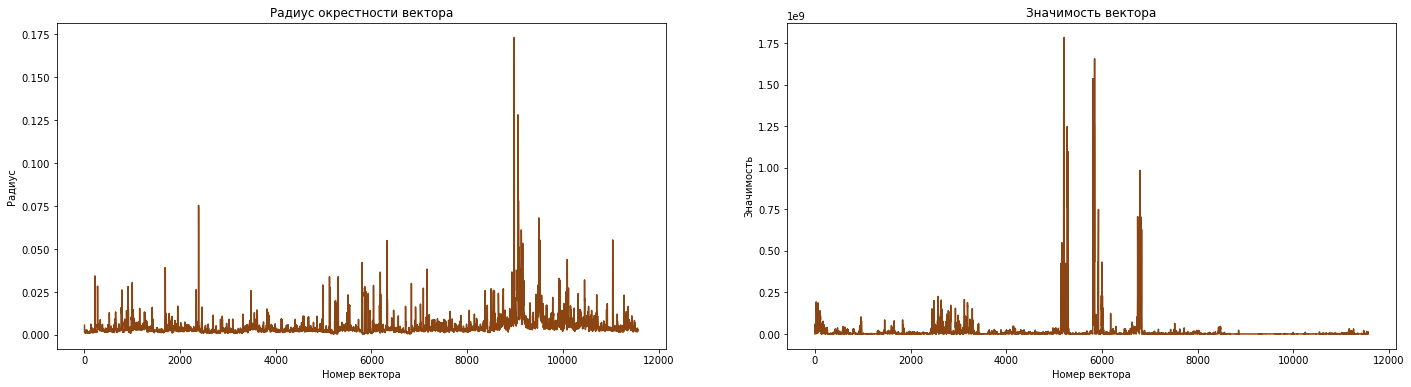

In [96]:
gemini_clustering.visualize_statistic()

Число кластеров: 2208.
Число сформированных кластеров: 603 (27.3 %).
Доля векторов, отнесенных к шуму: 34.3 %.


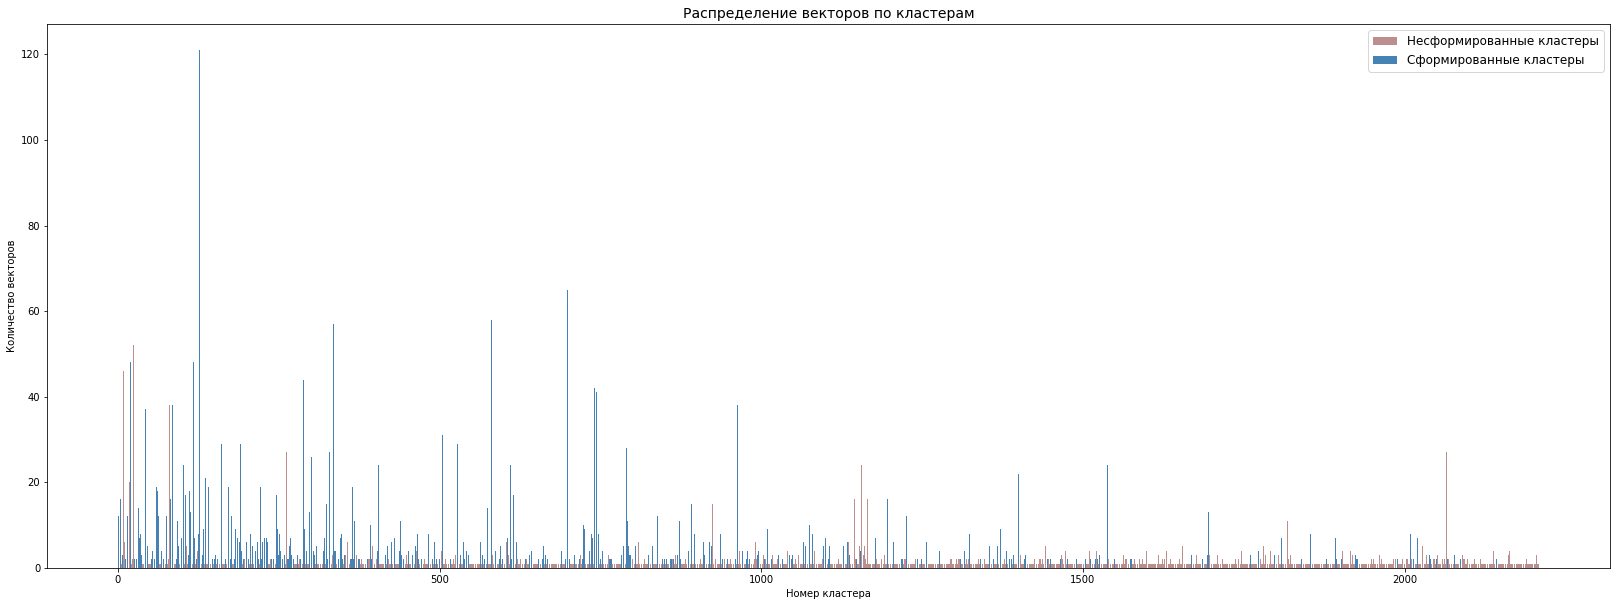

In [97]:
gemini_clustering.print_clusterisation_info(with_noise=0)

In [98]:
set_size_3, pred_val_3 = gemini_clustering.get_one_step_prediction(print_info=1)

Найдено возможных прогнозных значений: 85. Единое прогнозное значение равно 6384.92.


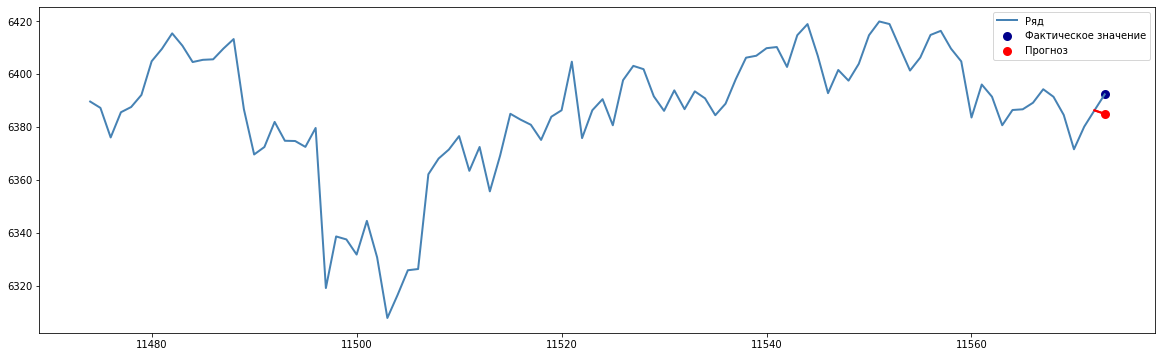

In [100]:
one_step_prediction_visualize(gemini_data['mid price'].values, pred_val_3, last_train = 100)

### Прогноз на несколько шагов вперед

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

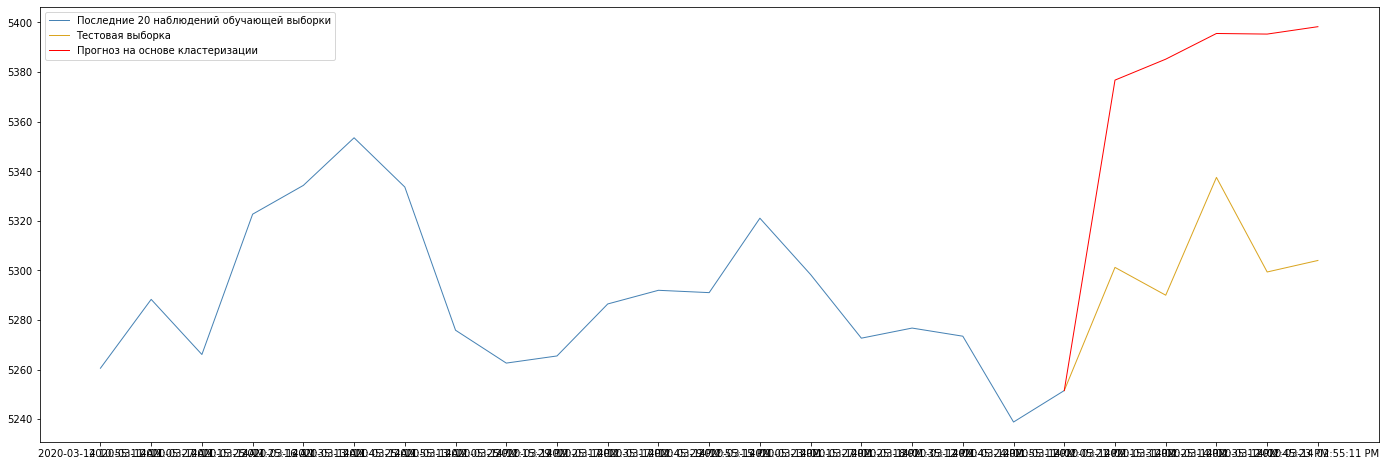

Число непрогнозируемых точек = 0


In [72]:
data_g = gemini_data[['date', 'mid price']]
data_g.columns = ['ds', 'y']
#data_g['ds']= pd.to_datetime(data_g['ds'])

model_gemini =  model_comparison(data_g)
model_gemini.clusterization_based_algorithm(display_forecast=1, normalize=1, m=10, delta=0.1, n_steps=5, one_value_method='weighted average', w_=1, last_train=20)

### Сравнение моделей

In [134]:
data_g = gemini_data[['date', 'mid price']]
data_g.columns = ['ds', 'y']
#data_g['ds']= pd.to_datetime(data_g['ds'])

model_gimini =  model_comparison(data_g)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE =  2843312.0101102674 
 MAPE =  0.2536564285875504 



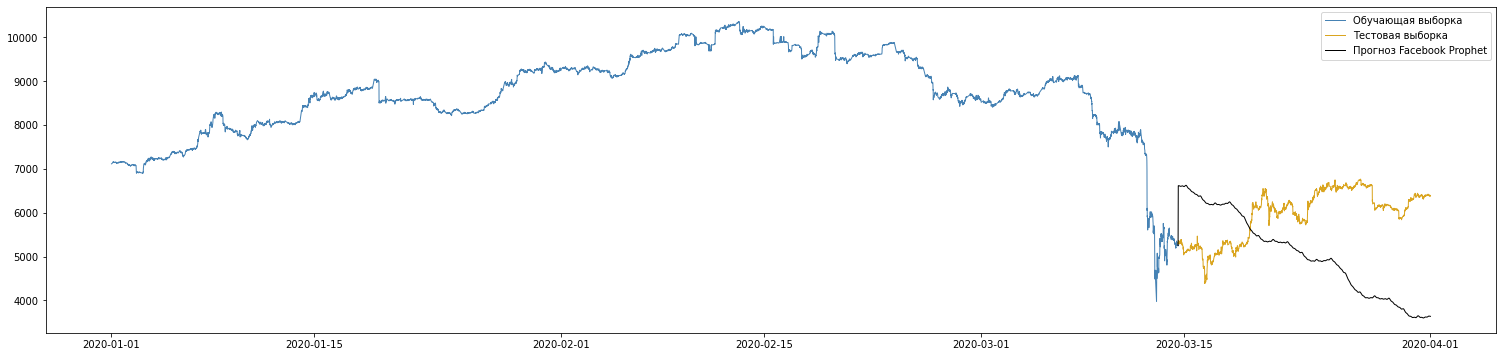

In [136]:
model_gimini.Prophet_forecast(display_components=0)

## Ряд 4

### Характеристики

In [44]:
brent_series = Series_data(brent['price'].values)

In [45]:
brent_series.print_info()

Кол-во наблюдений:  396
Минимальное значение:  9.82
Максимальное значение:  132.72
Среднее значение:  49.66


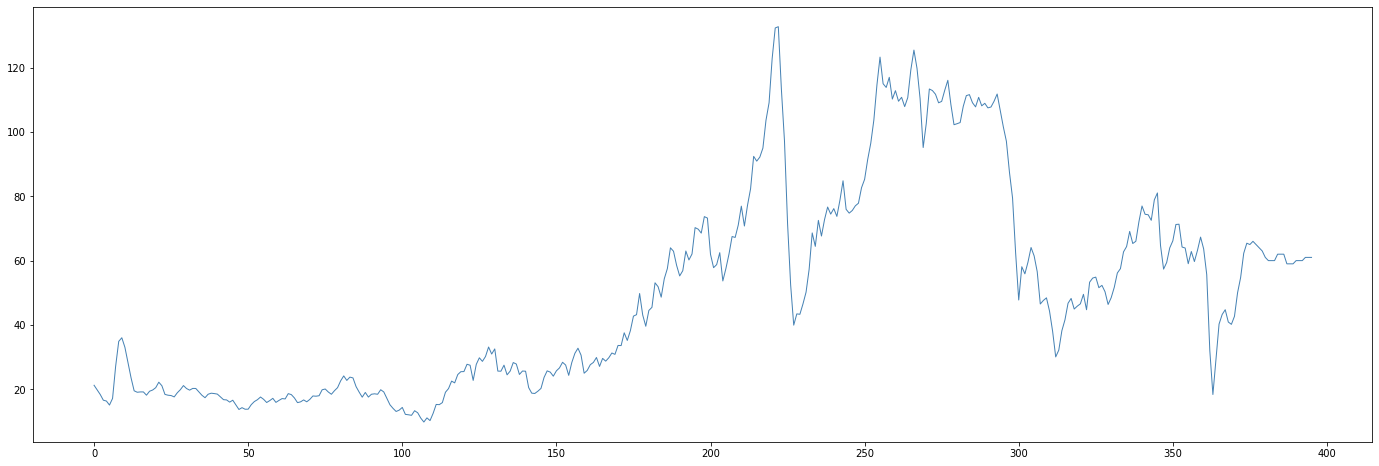

In [46]:
brent_series.get_visualization()

ADF-тест: The series is not stationary.
KPSS-тест: The series is not stationary.


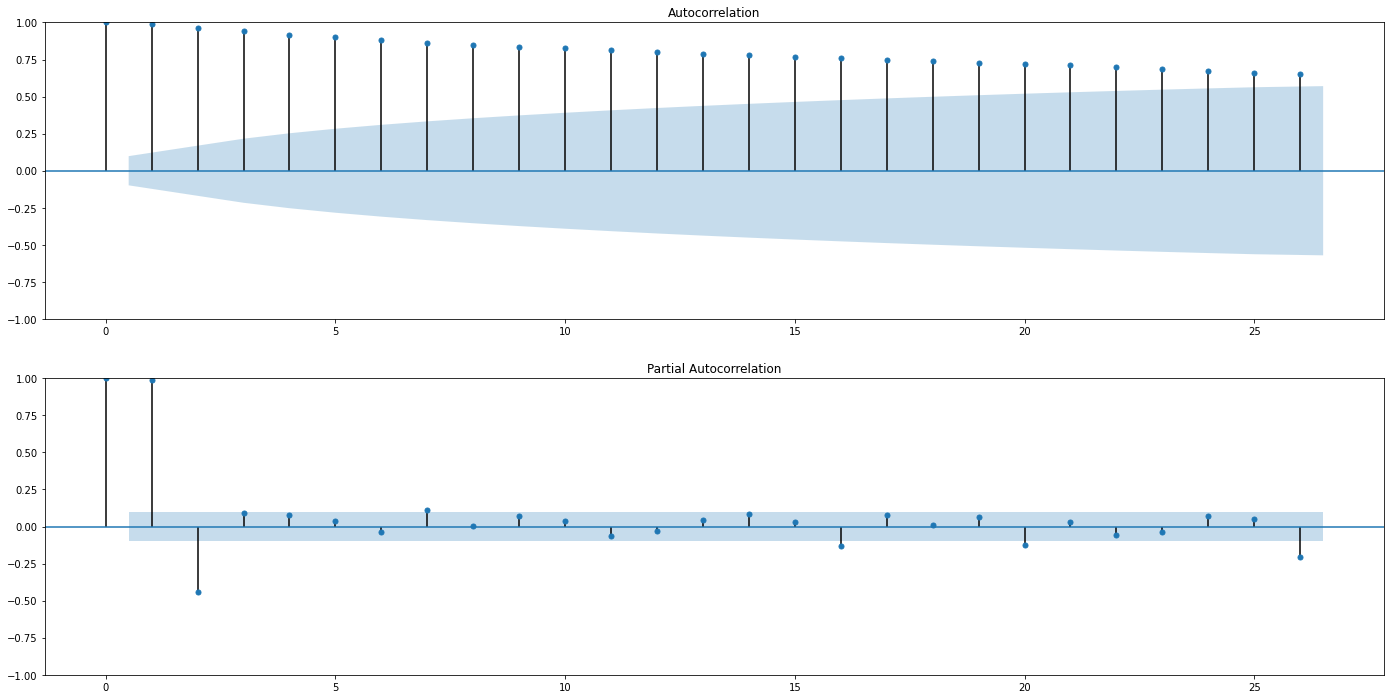

In [48]:
brent_series.stationarity_test(lev=0.05, fig_size=(24, 12))

### Прогноз на один шаг вперед

In [50]:
brent_clustering = Clustering_algorithm(series_data=brent['price'].values[:-1])

Число кластеров: 61.
Число сформированных кластеров: 19 (31.1 %).
Доля векторов, отнесенных к шуму: 27.4 %.


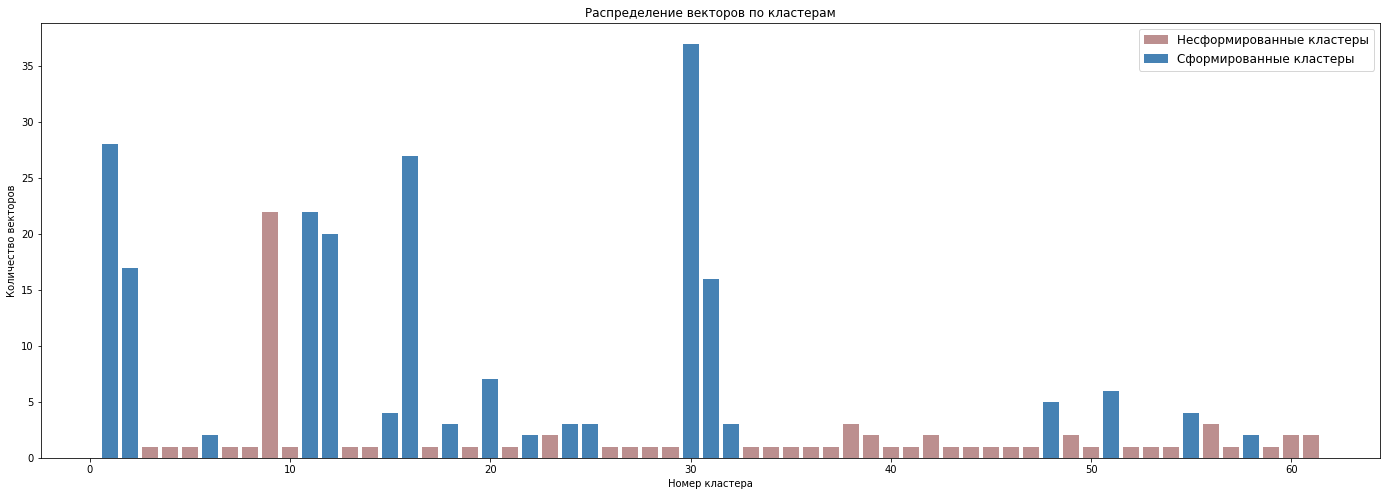

In [51]:
brent_clustering.print_clusterisation_info(with_noise=0)

In [52]:
set_size_4, pred_val_4 = brent_clustering.get_one_step_prediction(print_info=1)

Найдено возможных прогнозных значений: 3. Единое прогнозное значение равно 60.74.


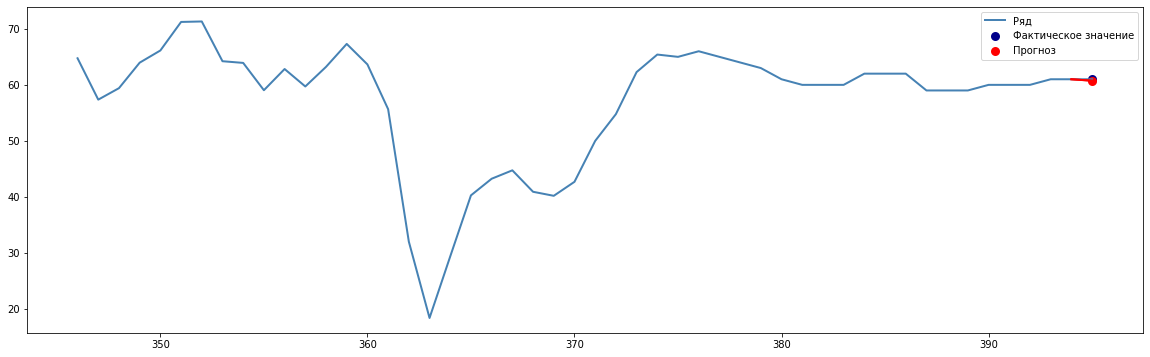

In [53]:
one_step_prediction_visualize(brent['price'].values, pred_val_4, last_train = 50)

### Прогноз на много шагов вперед

In [56]:
brent.columns = ['ds', 'y']
brent_model =  model_comparison(data_df=brent)

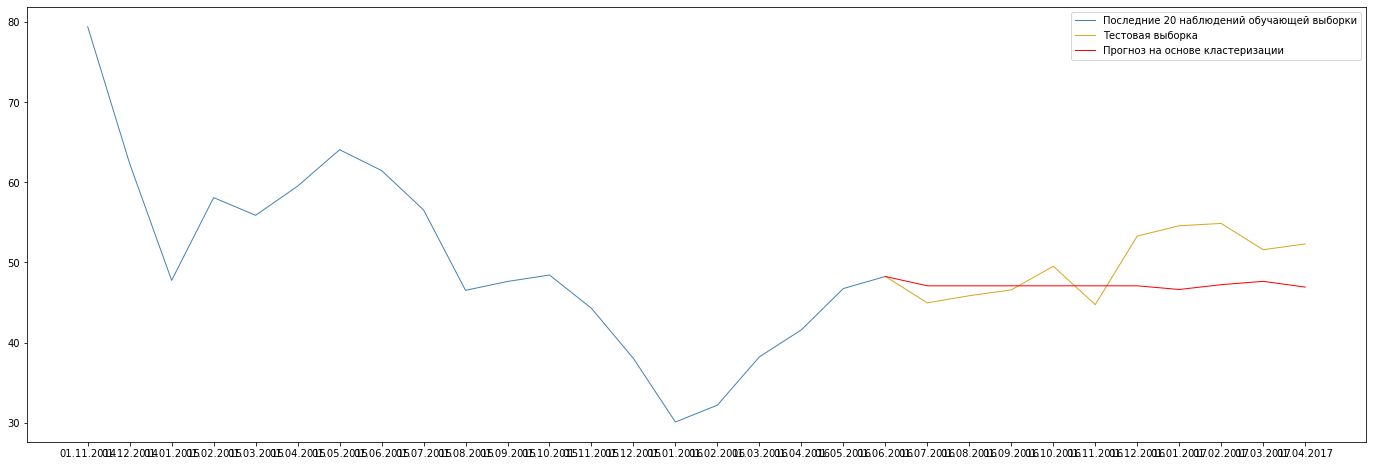

Число непрогнозируемых точек = 0


In [65]:
brent_model.clusterization_based_algorithm(display_forecast=1, normalize=1, m=4, delta=0.05, n_steps=10, one_value_method='weighted average', w_=1, last_train=20)

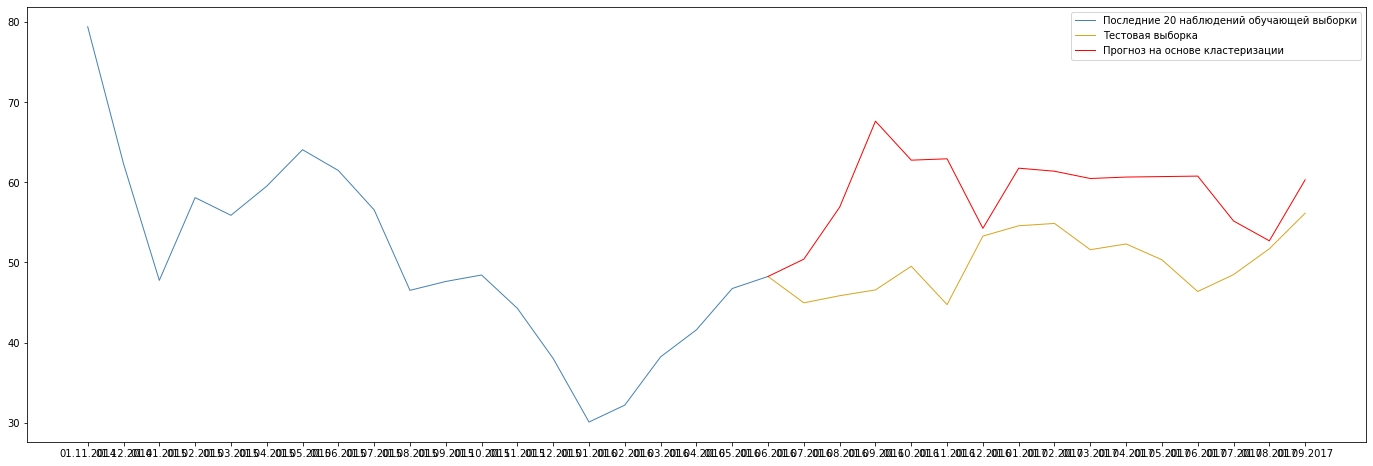

Число непрогнозируемых точек = 0


In [64]:
brent_model.clusterization_based_algorithm(display_forecast=1, normalize=1, m=4, delta=0.1, n_steps=15, one_value_method='weighted average', w_=1, last_train=20)

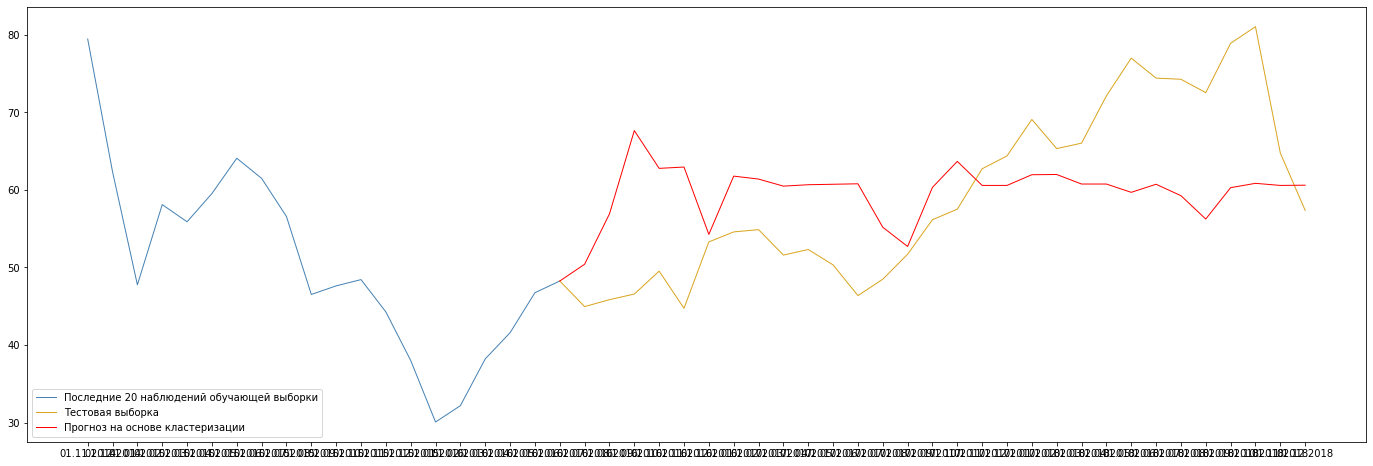

Число непрогнозируемых точек = 0


In [68]:
brent_model.clusterization_based_algorithm(display_forecast=1, normalize=1, m=4, delta=0.1, n_steps=30, one_value_method='weighted average', w_=1, last_train=20)